# Regression-based fault detection and isolation (FDI)

Authors: Lilach Goren Huber & Manuel Arias Chao, {gorn, aria}@zhaw.ch 

Zurich University of Applied Sciences, Technikumstrasse 81, Winterthur, 8400 Switzerland

# Introduction
This Jupyter notebook reimplements the solution strategy introduced in [1] for early fault detection and isolation in wind turbines. The proposed strategy aims to learn a deep learning model that accurately describes the sensor readings under "healthy" system conditions. An anomaly (potentially a fault) is then associated with sensor readings (also patterns) that the model poorly estimates. This is a classic anomaly detection problem. 

Anomaly detection can be addressed through various techniques. One very common technique is based on the reconstruction of the input data. A machine learning model (an autoencoder neural network is an example) is trained to reconstruct healthy data. At prediction time, the trained model provides small reconstruction errors for healthy inputs and large reconstruction errors for inputs during faulty operation (unobserved during training). Here we propose to use a different technique based on regression instead of reconstruction. In this case, a regression model is trained to learn an input-output mapping between sensor values. The input variables come from different sensors than the output ones. This separation between inputs and outputs is based on the physical understanding of the system's failure modes. 

In this Jupyter notebook, we implement a regression model covering an input-output mapping in the form of a deep neural network with **fully connected layers**, also known as a Multilayer Perceptron or an MLP. The input-output mapping is based on the expected physical dependencies of the system. Therefore, the **proposed method makes use of this form of technical knowledge that is often available for a large range of technical systems**. 

It is important to highlight that the inputs and outputs variables are thus assigned a physical meaning, and, as far as possible, they are related to each other on the basis of process knowledge.

The proposed method is compared to a traditional auto-encoder (AE) method [3] where anomalous patterns correspond to poorly reconstructed signals.

While the original work [1] is demonstrated in a case study of wind turbines using 10-minute SCADA, in this tutorial, we will show that the proposed method is generic to a large range of systems. In particular, we demonstrate its applicability dataset of turbofan engines from NASA [2].

The case study uses the **new C-MAPSS** (Commercial Modular Aero-Propulsion System Simulation) dataset from NASA for aircraft engines. The dataset was generated by the ETHZ IMS chair with the C-MAPSS dynamical model in the context of a collaboration with NASA Ames.

---
**Structure of the notebook**

The notebook is divided into five parts:

* Part 0: **Data exploration and visualization**

* Part 1: **Data pre-preprocessing**

* Part 2: **Create a reconstruction model**

* Part 3: **Fault diagnostics with a regression model**

* Part 4: **Model comparison and summary**
---

**Notes:** 
- (1) If you have a question about this case study, we encourage you to reach us during the PHM22 conference or email us at {gorn, aria}@zhaw.ch 
- (2) Since you might still need to become familiar with the new C-MAPSS dataset and diagnostics solution strategies implemented, this Jupyter notebook includes extensive descriptions.
- (3) The original implementation in [1] used convolutional neural networks (CNN). In this tutorial, we focus on MLP in order to reduce the computational load. The interested reader is encouraged to try alternative NN configurations.
- (4) Feel free to re-use the code provided as long as you make reference to this original work.
---

**References:**

[1] Ulmer, Markus; Jarlskog, Eskil; Pizza, Gianmarco; Goren Huber, Lilach, 2020. Cross-turbine training of convolutional neural networks for SCADA-based fault detection in wind turbines [Paper]. In: Proceedings of the Annual Conference of the PHM Society 2020. 12th Annual Conference of the PHM Society, virtual, 9-13 November 2020. PHM Society. Verfügbar unter: https://doi.org/10.36001/phmconf.2020.v12i1.1205

[2] Arias Chao, Manuel, Chetan Kulkarni, Kai Goebel, and Olga Fink (2021b). “Aircraft Engine
Run-to-Failure Dataset under Real Flight Conditions for Prognostics and Diagnostics”.
In: Data 6.1, p. 5. issn: 2306-5729. doi: 10.3390/data6010005.  https://www.mdpi.com/2306-5729/6/1/5

[3] Z Yang, B Xu, W Luo, F Chen, "Autoencoder-based representation learning and its application in intelligent fault diagnosis: A review" In: Measurement, 2021 - Elsevier

[4] Frederick, D.K.; Decastro, J.A.; Litt, J.S. User’s Guide for the Commercial Modular Aero-Propulsion System
Simulation (C-MAPSS). Technical report, NASA, 2007

[5] Ryan May, Jeffrey Csank, Thomas Lavelle, Jonathan Litt, and Ten-Huei Guo. A high-fidelity
simulation of a generic commercial aircraft engine and controller. In 46th AIAA/ASME/SAE/ASEE
Joint Propulsion Conference & Exhibit, page 6630, 2010

## Problem formulation: Fault detection & isolation (diganostics)
In this notebook, we develop a fault diagnostics model at time $t_a$ from a multivariate time series of condition monitoring sensor readings $X_s = [x_s^{(1)}, \dots, x^{(m)}]^T$, where each observation $x_s^{(i)} \in R^{n}$ is a vector of $n$ raw measurements. The corresponding system health condition (i.e., healthy or faulty) is partially known and denoted as $H_s = [h_s^{(1)}, \dots, h_s^{(m)}]^T$ with $h_s^{(i)} \in \{0,1\}$. Concretely, we consider the situation where certainty regarding healthy system conditions (i.e., $h_s^{(i)}=1$) is only available up to a past point in time $t_b$ when the system condition was assessed and confirmed as healthy by maintenance engineers, e.g., during an inspection. This partial knowledge of the true health allows the definition of two subsets of the available data: a $\textit{labeled}$ subset $\mathcal{D}_{L} = \{(x_s^{(i)}, h_s^{(i)})\}_{i=1}^{u}$ with $h_s^{(i)}=1$ corresponding to known healthy system conditions and an $\textit{unlabeled}$ subset $\mathcal{D}_{U} = \{x_s^{(i)}\}_{i=u+1}^{m}$ with unknown system health conditions (i.e., the system health conditions are not associated with either the healthy or faulty label). The unlabeled dataset is expected to contain data from both healthy and faulty system conditions. However, neither the types of faults nor their evolution with time is known. In this notebook, we implement a method to detect and isolate faulty conditions present in ${D}_{U}$. Moreover, we will test the generalization capability of the method on a test set ${D}_{T}$.

**Note:** in the original work [1], the definition of the health index (or anomaly score) is opposite to the one we use throughout this notebook (with 0 representing healthy conditions and one faulty condition). 

## Solution strategy

To simultaneously detect and isolate faulty conditions, we will resort to a model $\mathcal{G}$ that emulates the healthy behavior of the system. Once the model is available will make use of a traditional residual approach. The residuals (i.e., the delta between sensor readings and modes predictions) allow isolating which sensors are most affected by a fault.

Implementing this solution strategy requires the following steps:

* **Step 1:** Model the healthy system response i.e. sensor readings $x_s^{(t)} \in \mathcal{D}_{L}$. Create a dynamical model $\mathcal{G}$. 
* **Step 2:** Compute the expected, i.e., model predictions response of the system $\hat{x}_{s*}^{(t)}\in \{\mathcal{D}_{U},\mathcal{D_{T}}\}$
* **Step 3:** Compute residuals between sensor readings $x_s^{(t)}$ and model predictions $\hat{x}_s^{(t)}$ i.e., $\delta^{(t)}$ .
* **Step 4:** Identify residuals components $\delta_k^{(t)}$ with larger deviations. Hopefully, they indicate the location of the fault.

### Step 1: Model the healthy response of the system i.e., sensor readings $x_s^{(t)} \in \mathcal{D}_{L}$
We want to create a model replicating the sensor data's dynamic response from a turbofan engine. Since we might not have the required knowledge about gas turbine thermodynamics or physics, we will resort to a data-driven model of the sensor readings.

In particular, we will consider two learning strategies to learn a dynamical system $\mathcal{G}$ that approximates the healthy expected system response $x_s$.

First, we will resort to an AE network that approximates $x_s^{(t)}$ given current observations $x_s^{(t)}$ and control variables $w^{(t)}$, resulting in:

\begin{equation}
  [\hat{w}^{(t)}, \hat{x}_s^{(t)}] = \mathcal{G}_{AE}(w^{(t)}, x_s^{(t)})
\end{equation}

Second, we also build a dynamical system that approximates $x_s^{(t)}$ given only the control variables $w^{(t)}$, resulting in:

\begin{equation}
  \hat{x}_s^{(t)} = \mathcal{G}_{phy}(w^{(t)})
\end{equation}

We will model $\mathcal{G}$ as a multivariate regression model using a deep fully connected neural network.


### Step 2: Compute the expected healthy response of the system i.e., $\hat{x}_{s*}^{(t)}\in \{\mathcal{D}_{U},\mathcal{D_{T}}\}$
Once $\mathcal{G}$ is learned with $[w^{(t)}, x_s^{(t)}] \in \mathcal{D}_{L}$ then it can be used to estimate the expected healthy system response  $[w_*^{(t)}, x_{s*}^{(t)}] \in \{\mathcal{D}_{U},\mathcal{D_{T}}\}$:

\begin{equation}
  {\hat{y}}^{(t)} = \mathcal{G}_{AE}(w^{(t)}, x_s^{(t)})  \quad with  \quad {\hat{y}}^{(t)} = [\hat{w}_{*}^{(t)}, \hat{x}_{s*}^{(t)}] 
\end{equation}

\begin{equation}
  {\hat{y}}^{(t)} = \mathcal{G}_{phy}(w_{*}^{(t)}, x_{s*}^{(t)})  \quad with  \quad {\hat{y}}^{(t)} = \hat{x}_s^{(t)}
\end{equation}

### Step 3: Compute residuals between sensor readings $x_s^{(t)}$ and model predictions $\hat{x}_{s*}^{(t)}$.

\begin{equation} 
  \delta^{(t)}= {x_s}^{(t)} - {\hat{x}_{s*}^{(t)}} 
\end{equation}


### Step 4: Identify residuals with larger deviations 

The dynamical system $\mathcal{G}$ allows the computation of the expected signal values under the training input conditions (i.e., $w$). The output of the $\mathcal{G}$, i.e., $\hat{x}_{s*}^{(t)}$ will deviate from the input value $x_{s*}$ when the inner relationship of a new data point $x_{s*}^{(j)} \in \{\mathcal{D}_{U},\mathcal{D_{T}}\}$ does not correspond to the one observed in the training set $S_{T}$. Therefore, we compute the absolute deviation that each component of the reconstructed signals has (i.e., $|\delta^{(t)}_k|$) relative to the error observed in the validation dataset $S_V$ (i.e., healthy operation conditions).

\begin{equation}
  d_I(x_k^{(j)};\nu_k) =  \frac{|\delta_k^{(j)}|}{\nu_k}
\end{equation}

where $\nu$ corresponds to a normalizing threshold given by the 99.9\% percentile of the absolute error of the prediction of $F$ in the validation set $S_{V}$


\begin{equation}
  \nu_k = P_{99.9}\big(\{|\delta_k^{(i)}| \; | \; x_k^{(i)}\in S_V\}\big) % \; \forall
\end{equation}

$d_I(x_k^{(j)};\nu_k)$ is an unbounded measure of similarity between the signal value predicted by $\mathcal{G}$ and the expected or true signal value.

### Step 5: Fault detection with an unbounded anomaly score

Anomalies are detected whenever the anomaly score exceeds 1:

\begin{equation}
  s_I(x_k^{(j)};\nu_k) =  \frac{\max|\delta_k^{(j)}|}{\nu}
\end{equation}

where $\nu$ corresponds to a normalizing threshold given by the 99.9\% percentile of the absolute error of the prediction of $F$ in the validation set $S_{V}$


\begin{equation}
  \nu = P_{99.9}\big(\{\max|\delta_k^{(i)}| \; | \; x_k^{(i)}\in S_V\}\big) % \; \forall
\end{equation}



The estimated health conditions are thus given by: 

\begin{equation}
    \hat{h} = 
    \begin{cases} 
        1 &   s_I  \le 1  \\
        0 & \text{otherwise} 
    \end{cases}
\end{equation}

##  Dataset: N-CMAPSS DS02_v0*

This case study makes use of a synthetic dataset with run-to-failure degradation trajectories of a small fleet comprising nine turbofan engines with unknown and different initial health conditions. The dataset was generated with the Commercial Modular Aero-Propulsion System Simulation (CMAPSS) model. Real flight conditions, as recorded on board commercial jets, were taken as input to the CMAPSS model. The dataset contains $N=6$ training units ($u=$ 2, 5, 10, 16, 18 \& 20) and $M=3$ test units ($u=$ 11, 14 \& 15).  

Two distinctive failure modes are present in the available dataset ($\mathcal{D}$). Units 2, 5, and 10 have failure modes of an $\textit{abnormal}$ high-pressure turbine (HPT) efficiency degradation. Units 16, 18, and 20 are subject to a more complex failure mode that affects the low-pressure turbine (LPT) efficiency and flow in combination with the high-pressure turbine (HPT) efficiency degradation. Test units are subjected to the same complex failure mode. The degradation of the affected system components follows a stochastic process with a linear $\textit{normal degradation}$ followed by a steeper $\textit{abnormal degradation}$. The degradation rate of each component varies within the fleet. The transition from $\textit{normal}$ to $\textit{abnormal}$ degradation is smooth and occurs at different cycle times for each unit. The transition time ($t_{s}$) is dependent on the operating conditions, i.e., flight and degradation profile. It should be noted that although the degradation profiles of individual components show nearly overlapping trajectories, the combined profile (i.e., the profile in three dimensions) is clearly different.

The sampling rate of the data is 0.1Hz, resulting in a total dataset size of 0.53M samples for model development and 0.12M samples for testing. It is worth noting that while test unit 14 is a short flight engine with the lowest amount of flight time (0.16M seconds), it has the largest number of flight cycles. More details about the generation process and a more recent version of this dataset (i.e., DS02) can be found in https://www.mdpi.com/2306-5729/6/1/5.

The tables below provide the name, description, and units of each variable in the dataset. The variable symbol corresponds to the internal variable name in CMAPSS. The descriptions and units are reported as in the model documentation [1].

**Scenario descriptors (i.e. Flight Data) - $[w]$**

| \# | Symbol | Description                    | Units       |
|----|--------|--------------------------------|-------------|
| 1  | alt    | Altitude                       | ft          |
| 2  | Mach   | Flight Mach number             | -           |
| 3  | TRA    | Throttle-resolver angle        | \%          |
| 4  | T2     | Total temperature at fan inlet | $^{\circ}$R |

**Sensor readings - $[x_s]$**

| \# | Symbol | Description                        | Units       |
|----|--------|------------------------------------|-------------|
| 1  | Wf     | Fuel flow                          | pps         |
| 2  | Nf     | Physical fan speed                 | rpm         |
| 3  | Nc     | Physical core speed                | rpm         |
| 4  | T24    | Total temperature at LPC outlet    | $^{\circ}$R |
| 5  | T30    | Total temperature at HPC outlet    | $^{\circ}$R |
| 6  | T40    | Total temperature at burner outlet | $^{\circ}$R |
| 7  | T48    | Total temperature at HPT outlet    | $^{\circ}$R |
| 8  | T50    | Total temperature at LPT outlet    | $^{\circ}$R |
| 9  | P15    | Total pressure in bypass-duct      | psia        |
| 10 | P2     | Total pressure at fan inlet        | psia        |
| 11 | P21    | Total pressure at fan outlet       | psia        |
| 12 | P24    | Total pressure at LPC outlet       | psia        |
| 13 | P30    | Total pressure at HPC outlet       | psia        |
| 14 | Ps30   | Static pressure at HPC outlet      | psia        |
| 15 | P40    | Total pressure at burner outlet    | psia        |
| 16 | P50    | Total pressure at LPT outlet       | psia        |

**Performance gap - $[\theta]$**

| \# | Symbol         | Description             | Units |
|----|----------------|-------------------------|-------|
| 1  | HPT\_eff\_mod  | HPT efficiency modifier | -     |
| 2  | LPT\_eff\_mod  | LPT efficiency modifier | -     |
| 3  | LPT\_flow\_mod | HPT flow modifier       | -     |

In addition to $w, x_s$ and $\theta$ the dataset also provides the variables $Unit$, $Cycle$ and $RUL$; which contains labels with the Unit name, cycle time, and RUL (in cycles) for each sample time. The location of the CM data $[w, x_s]$within the turbofan engine, i.e., their topological dependency, is provided in the next section.

***Note**: DS02_0 v0 is a customized version of the official sets DS02 to reduce the computational load of this tutorial.

## C-MAPSS dynamical model
The C-MAPSS dynamical model is a high fidelity computer model for simulation of a realistic large commercial turbofan engine. Although most of the implementation details of the CMAPSS engine model are not publicly available, the user manual [4] and the documentation of the similar model C-MAPSS40k [5] provide some details about the software and control implementation. In brief, the CMAPSS engine model represents a generic, high-bypass, twin-spool commercial turbofan engine. The engine consists of six main components: fan, low-pressure compressor (LPC), high-pressure compressor (HPC), combustor or burner, high-pressure turbine (HPT), and low-pressure turbine (LPT). The HPC and HPT are connected through the core shaft or high-speed shaft; the fan, LPC, and LPT are all connected to the fan shaft or low-speed shaft [5]. In addition to these turbo-machinery components and the combustor, the engine has an inlet at the front, a nozzle at the rear, a bypass duct, a variable-sized inter-stage bleed valve, a set of variable-angle stator or guide vanes, and a number of cooling bleeds. A schematic of the engine is shown in the Figure below. The CMAPSS model includes two types of models: 1) a transient aero-thermodynamic engine model and 2) an engine controller that allows the engine to be operated over a wide range of thrust levels spanning the full spectrum of flight conditions.

$\textit{Aero-thermodynamic Engine Model}$. The aero-thermodynamic engine model is a physics-based, component-level model where each of the engine components is represented as an infinitesimally small volume [5]. The engine is then balanced by mass flow rate continuity through the components. The thermodynamic model uses traditional off-design performance modeling approaches, common in gas turbines, that resort to 'component maps' of the rotating components. Thereby, this modeling strategy captures the gross characteristics of each engine component. The engine thermodynamic model also includes an atmospheric model modeling covering the following flight condions: (i) altitudes from sea level to 40,000 ft, (ii) Mach numbers from 0 to 0.90, and (iii) sea-level temperatures from –60 to 103 $^{\circ}$F

$\textit{Engine Controller}$. The controller converts the throttle command from the pilot into thrust while providing safe operation. The controller has two main components: the power management and protection logic controllers. The power management controller determines an engine pressure ratio (EPR), which is the ratio of turbine exit pressure to inlet pressure (P50/P2), or fan speed (Nf) setpoint based on the PLA, altitude, Mach number, and ambient temperature that, when achieved, results in the desired linear thrust profile. Protection logic aims at providing safe and smooth thrust transitions between distant setpoints. Safe operation implies 1) the protection of physical components by preventing overstress and 2) the avoidance of operability limits (e.g., compressor surge, stall, combustor lean blow-out). This protection is achieved through the use of controller limits on physical variables including limits on the maximum fan speed (Nf), core speed (Nc), and burner pressure (Ps3). The control model resorts to common industry control theory and linear engine models.

<img src="../images/cmapss.png" style="width:750px;height:550px;">

The resuting physics-based performance model provide estimations of observed system dynamics ($\hat{x}_s$) and non-observable properties ($x_v$) given some input operating conditions ($w$). This model also serve as structural causal models, relating the measured properties (i.e., $x_s$ and $w$) to the performance gap parameters $\theta$. The  resuting physics-based performance model involve a mathematical formulation of the physical principles governing the system dynamics in the form of differential algebraic equations (DAEs) or state-space representations:
 
\begin{align} 
  0 = F_s(\dot{x}_v, x_v, w,\theta) \\
  \hat{x}_s = F_x(\dot{x}_v, x_v, w,\theta)
\end{align}
    
where $F_s$ denotes the system dynamic state and $F_x$ the predicted system dynamics. 
    
The solution of the system dynamic state, by means of a root-finding algorithm, is handled internally so that from a user’s perspective, the model can be summarised with the following system equation:

\begin{align} 
  [\hat{x}_s, x_v] = F(w,\theta)
\end{align}

## Packages ##

Let's first import all the packages that you will need during this assignment.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [pandas](https://pandas.pydata.org/) is a software library written for Python for data manipulation and analysis.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis. 
- [seaborn](https://seaborn.pydata.org/) is another famous library to plot graphs in Python.
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.
- [tensorflow](https://www.tensorflow.org/) is a library for machine learning and artificial intelligence.
- In addition we provide various useful functions (i.e., auxiliary functions) used in this notebook.

In [1]:
import os
import h5py
import time
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas import DataFrame
from itertools import product
from matplotlib import gridspec
from operator import itemgetter
from time import gmtime, strftime
from sklearn.model_selection import train_test_split

In [2]:
print(tf.version.VERSION)

2.8.0


### Auxiliary plotting functions

In [3]:
def plot_variables_iso(data, figsize=10, filename=None,
                       labelsize=16, y_min=None, y_max=None, x_min=None, x_max=None):
    """
    Given a "data" dictionary it generates a plot of size 'figsize' and 'labelsize'.
    If filename is provided, the resulting plot it saved.
    
    Expected keys: 'variables', 'ds_name', 'legend'
        data[0]['variables']: contains a list with the variables names that should be plotted
        data[0]['ds_name']: contains the data subsets to be ploted 
        data[0]['legend']: contains LaTex formated legend of each plot 

    Optional keys:
        data[0]['xlabel'] = e.g. 'Time [cycles]' , default: 'Index'                          
        data[0]['ylabel']: If data[0]['ylabel']='score' then ylabel is 'Anomaly score' and title
        data[0][jj]['marker']:        
        data[0][jj]['units']:
    
    """
    plt.clf()
    
    input_dim = len(data[0]['variables'])
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    fig  = plt.figure(figsize=(figsize, max(figsize, rows*2)))    
    
    color_dic = {'dev': 'C0', 'train': 'C0', 'lab': 'C0',  'val': 'C1', 'unl': 'C2', 'test': 'C3',
                 '1': 'C0', '2': 'C1', '3': 'C2', '4': 'C3', '5': 'C4', '6': 'C5', '7': 'C6', '8': 'C7',
                 '9': 'C8', '10': 'C9', '11': 'C1', '12': 'C11', '13': 'C12', '14': 'C2', '15': 'C3',
                 '16': 'C15', '17': 'C16', '18': 'C17', '19': 'C18', '20': 'C19'}
    
    # Plot dataset types
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for jj in data[0]['ds_name']:
            if 'units' in data[0][jj]:
                for unit in np.unique(data[0][jj]['units']):
                    mask = np.ravel(data[0][jj]['units']== unit)
                    ax.plot(data[0][jj]['x'][mask], data[0][jj]['y'][mask,n], '.' ,
                            color=color_dic[str(int(unit))],
                            markeredgewidth=0.25, markersize=8)
            else:
                if 'marker' in data[0][jj]:
                    ax.plot(data[0][jj]['x'], data[0][jj]['y'][:,n], data[0][jj]['marker'],
                            markeredgewidth=0.25, markersize=8)
                else:
                    ax.plot(data[0][jj]['x'], data[0][jj]['y'][:,n], '.' ,
                            markeredgewidth=0.25, markersize=8)                
            
        # Axis adjusments (max, min values, labelsize and rotations)
        if y_min !=None:
            ax.set_ylim(bottom=y_min)
        if y_max !=None:
            ax.set_ylim(top=y_max)
        if x_max !=None:    
            ax.set_xlim(0, x_max)
        ax.tick_params(axis='x', labelsize=labelsize) # rotation=45
        ax.tick_params(axis='y', labelsize=labelsize)
        
        # Labels
        if 'xlabel' in data[0]:
            plt.xlabel(data[0]['xlabel'], fontsize=labelsize) 
        else:
            plt.xlabel('Index', fontsize=labelsize)
        if 'ylabel' in data[0]:
            if data[0]['ylabel']=='score':
                plt.title(data[0]['variables'][n], fontsize=labelsize)
                plt.ylabel('Anomaly Score', fontsize=labelsize)
            else:
                plt.ylabel(data[0]['ylabel'][n], fontsize=labelsize)
        else:
            plt.ylabel(data[0]['variables'][n], fontsize=labelsize)
        
        # Legend
        leg = []
        for jj in data[0]['ds_name']:
            if 'units' in data[0][jj]:
                for u in np.unique(data[0][jj]['units']):
                    leg.append('Unit ' + str(int(u)))            
            elif (('units' not in data[0][jj]) and ('legend' in data[0])):
                leg = data[0]['legend']
        plt.legend(leg, fontsize=labelsize-2, loc='best')
        
    # draw solid white grid lines
    plt.grid(color='w', linestyle='solid')
    
    plt.tight_layout()
    
    if filename == None:
        plt.show()
    else:
        print(filename + '.png')
        plt.savefig(filename + '.png', format='png', dpi=300) 
    plt.close()
    
color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                  'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C1',
                  'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C2', 'Unit 15': 'C3', 'Unit 16': 'C15',
                  'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19',
                  'dev':'C0', 'threshold': 'k'} 

def subplot_per_unit(data, color_dic):
    """
    """    
    plt.clf()
    rows, cols = [len(data), 1]
    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure(figsize=(10,10))
    for n in range(rows):
        ax = fig.add_subplot(gs[n])
        leg = []
        for j in data[ii]['ds_name']:
            # Plot data segments
            unit = data[n][j]['units'][0]
            ax.plot(data[n][j]['x'], data[n][j]['y'], linestyle='None', marker='.', color=color_dic[str(unit)])

            # Plot vertical lines
            if 'fault' in data[n][j]:
                plt.plot([data[n][j]['fault'], data[n][j]['fault']], [0, 1], 'k',
                         markerfacecolor='none', linewidth=2, linestyle='--')
        
        # legend
        leg.append('Unit ' + str(unit))

        # Adjustments
        plt.yticks([0, 1])
        plt.ylabel(data[n]['ylabel'], fontsize=16)
        plt.xlabel(data[n]['xlabel'], fontsize=16)
        plt.legend(leg, loc='best', fontsize=15)
        #plt.title(data[n]['title'])
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        
    fig.tight_layout()

### Auxiliary data processing functions

In [4]:
def extract_units_ds(id_en, ds, units):
    '''
    Creates data subset 'ds_sub' with only units ids indicates in 'id_en'
    '''
    
    # Set-up
    ds_sub = []
    units_unique = np.unique(units)

    # Process
    for i in units_unique:
        if i in id_en:
            idx = np.ravel(units==i)
            ds_sub.append(ds[idx,:])           
    
    return np.concatenate(ds_sub, axis=0)


def normalize_data(x, lb, ub, max_v=1.0, min_v=-1.0):
    '''
    Max-Min normalize of 'x' with max value 'max_v' min value 'min_v'
    '''

    # Set-up
    if len(ub)==0:
        ub = x.max(0) # OPTION 1
        #ub = np.percentile(x, 99.9, axis=0, keepdims=True) # OPTION 2:
        
    if len(lb)==0:
        lb = x.min(0) 
        #lb = np.percentile(x, 0.1, axis=0, keepdims=True)
    
    ub.shape = (1,-1)
    lb.shape = (1,-1)           
    max_min = max_v - min_v
    delta = ub-lb

    # Compute
    x_n = max_min * (x - lb) / delta + min_v
    if 0 in delta:
        idx = np.ravel(delta == 0)
        x_n[:,idx] = x[:,idx] - lb[:, idx]

    return x_n, lb, ub 


# Split available dataset
def data_subset(X_data, Units, Cycles, U_sel, split_cycle=10):
    """
    Creates two dataset subsets. One containing labeled (healthy) data and another
    with unlabeled data
    
    Arguments:
    X_data -- np.array() with Xs data of shape (number of examples, number of features)
    U_sel -- list with selected unit number labels
    Units -- np.array() with unit number labels 
    Cycles -- np.array() with flight cycles numbers
    
    Returns:
    X_lab, X_unl -- np.arrays for {lab, unl}
    """
    
    # Set-up
    X_lab,  X_unl = [], []
    
    # Loop over units   
    for u in U_sel:
        unit = np.ravel(Units == u)
        X_unit = X_data[unit,:]
        C_unit = Cycles[unit,:]
        
        # Labeled healthy dataset
        mask = np.ravel(C_unit <=split_cycle)
        X_lab.append(X_unit[mask, :]) 
        
        # Unlabeled dataset
        X_unl.append(X_unit[~mask, :])      
         
    return np.vstack(X_lab), np.vstack(X_unl)

### Auxiliary evaluation functions

In [5]:
def mae_per_cycle(delta, units, cycles, option=None):
    # Set-up
    log_mae, log_units, log_cycles = [], [], []
    for unit in np.unique(units):
        mask_u = np.ravel(units == unit)
        delta_unit = delta[mask_u,:]
        C_unit = cycles[mask_u,:]
        # and then loop within unit's cycles
        for cycle in np.unique(C_unit):
            mask_c = np.ravel(C_unit == cycle)
            delta_unit_cycle = delta_unit[mask_c,:]
            dim = delta_unit_cycle.shape[0]
            if option == None:
                log_mae.append(np.sum(abs(delta_unit_cycle), axis=0)/dim)
                log_cycles.append(cycle)
                log_units.append(unit)
            elif option == 'max':
                log_mae.append(max(np.sum(abs(delta_unit_cycle), axis=0)/dim))
                log_cycles.append(cycle)
                log_units.append(unit)
            
    return np.array(log_mae), np.array(log_cycles), np.array(log_units)

def get_y_true(cycles, units, fault_onset):
    '''
    Given 'fault_onset' dictionary it provides the ground thruh health 
    '''    
    log_true = []
    for u in np.unique(units):
        mask_u = np.ravel(units == u)
        h_true_unit = np.where(cycles[mask_u] <= fault_onset[str(u)], 1, 0)
        log_true.append(h_true_unit)
        
    return np.hstack(log_true)

def evaluate_detection(y_actual, y_hat):

    # Set up
    TP, FP, TN, FN = 0, 0, 0, 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1
            
        if TP+FN==0:
            recall = np.nan 
        else:
            recall= TP/(TP+FN)
        if TP+FP==0:
            if TP==0:
                precision = 1.0
            else:
                precision = np.nan

        else:
            precision = TP/(TP+FP)
            
        F1 = 2*(recall*precision)/(recall+precision)

    return recall, precision

# Part 0: Data visualization and exploration 

Before starting with the model generation process, it is generally a good practice to visualize the dataset at hand. Therefore, to familiarize yourself with the dataset we will perform the following exploratory analysis of the dataset:

1. Report the name of the units in the training and test dataset, i.e., unique values in `U` variables.
2. Report the End of Life $t_{\text{EOL}}$ for training and test units
3. Analysis of operative conditions $w$. In particular, we will check if the training set and the test set cover roughly the same operating conditions. Can we say that operation profiles in the test set have the same distribution as the training set?
4. Analysis of sensor readings $x_s$. Create a visualization of the sensor reading profile during one single flight
5. Analysis of performance gap indicators $\theta$. Create a visualization of the degradation trajectories provided for training (i.e., N=6 engines) by plotting the traces of the model parameters $\theta$ vs. the time (e.g., variable value Vs. Cycle).

## Load Data

We load the data by running the following code below and report the shapes of the different set of variables.
Six set of data are provided for the training and test datasets: operative condition `W`, sensor readings `X_s`, performance gap indicators `T`, RUL label `R`, unit number label, `U` and flight cycle number `C`. The corresponding variables names.

In [6]:
ROOT_PATH = "../" # You need to set your own path here
PATH_IN = ROOT_PATH + "data"
SOURCE = 'CMAPSS_Dataset_DS02_Journal'

# Time tracking, Operation time (min):  0.004
t = time.perf_counter()

with h5py.File(PATH_IN + "/" + SOURCE + '.h5', 'r') as hdf:
# Nominal Training set
    W_dev = np.array(hdf.get('W_train'))                 # W
    Xs_dev = np.array(hdf.get('X_s_train'))              # X_s
    T_dev = np.array(hdf.get('T_train'))                 # T
    R_dev = np.array(hdf.get('Y_train'))                 # RUL  
    U_dev = np.array(hdf.get('U_train'))                 # Units
    C_dev = np.array(hdf.get('C_train'))                 # Cycles

# Nominal Test set - Past
    W_test = np.array(hdf.get('W_test'))                 # W
    Xs_test = np.array(hdf.get('X_s_test'))              # X_s
    T_test = np.array(hdf.get('T_test'))                 # T
    R_test = np.array(hdf.get('Y_test'))                 # RUL  
    U_test = np.array(hdf.get('U_test'))                 # Units
    C_test = np.array(hdf.get('C_test'))                 # Cycles
    
# Variable name
W_var = ['alt', 'Mach', 'TRA', 'T2']
Xs_var = ['T24', 'T30', 'T40', 'T48', 'T50', 
          'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50',
          'Nf', 'Nc', 'Wf']
T_var = ['HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod']

# Report dataset shapes
print('')
print ("number of development data examples = " + str(Xs_dev.shape[0]))
print ("Xs_dev shape: " + str(Xs_dev.shape))
print ("T_dev shape: " + str(T_dev.shape))
print ("W_dev shape: " + str(W_dev.shape))
print ("U_dev shape: " + str(U_dev.shape))
print ("C_dev shape: " + str(C_dev.shape))

print('')
print ("number of test data examples = " + str(Xs_test.shape[0]))
print ("Xs_test shape: " + str(Xs_test.shape))
print ("T_test shape: " + str(T_test.shape))
print ("W_test shape: " + str(W_test.shape))
print ("U_test shape: " + str(U_test.shape))
print ("C_test shape: " + str(C_test.shape))

print('')
print("Operation time (min): " , (time.perf_counter()-t)/60)
print('')    


number of development data examples = 526347
Xs_dev shape: (526347, 16)
T_dev shape: (526347, 3)
W_dev shape: (526347, 4)
U_dev shape: (526347, 1)
C_dev shape: (526347, 1)

number of test data examples = 125375
Xs_test shape: (125375, 16)
T_test shape: (125375, 3)
W_test shape: (125375, 4)
U_test shape: (125375, 1)
C_test shape: (125375, 1)

Operation time (min):  0.004481996666678849



##  Units Ids
We report the name of the units in the development and test dataset, i.e., unique values in `U` variables.

In [7]:
print('Engine units in developmenent dataset: ', np.unique(U_dev))

Engine units in developmenent dataset:  [ 2  5 10 16 18 20]


In [8]:
print('Engine units in test dataset: ', np.unique(U_test))

Engine units in test dataset:  [11 14 15]


As we case see, the dataset contains $N=6$ development units ($u=$ 2, 5, 10, 16, 18 \& 20) and $M=3$ test units ($u=$ 11, 14 \& 15). 

## End Of Life ($t_{\text{EOL}}$)

Report the $t_{\text{EOL}}$ for development and test units

In [9]:
# Development units
t_EOL_dev = []
for i in np.unique(U_dev):
    t_EOL_dev = t_EOL_dev + [int(C_dev[U_dev == i][-1])]
    print('Unit: ' + str(int(i)) + ' - Number of flight cyles (t_{EOL}): ', int(C_dev[U_dev == i][-1]))

# Test units
print('')
t_EOL_test = []
for i in np.unique(U_test):
    t_EOL_test = t_EOL_test + [int(C_test[U_test == i][-1])]
    print('Unit: ' + str(int(i)) + ' - Number of flight cyles (t_{EOL}): ', int(C_test[U_test == i][-1]))

Unit: 2 - Number of flight cyles (t_{EOL}):  75
Unit: 5 - Number of flight cyles (t_{EOL}):  89
Unit: 10 - Number of flight cyles (t_{EOL}):  82
Unit: 16 - Number of flight cyles (t_{EOL}):  63
Unit: 18 - Number of flight cyles (t_{EOL}):  71
Unit: 20 - Number of flight cyles (t_{EOL}):  66

Unit: 11 - Number of flight cyles (t_{EOL}):  59
Unit: 14 - Number of flight cyles (t_{EOL}):  76
Unit: 15 - Number of flight cyles (t_{EOL}):  67


## Operative Conditions $w$

We make use of the `sns.pairplot` to plot the pair plot of the development and test datasets. Please notice that this dataset is large, and it is recommended that you sample the data as follows:

`dim, size = W_dev.shape[0], 10000
 mask_dev = np.random.choice(dim, size, replace=False)
 W_dev[mask_dev]`

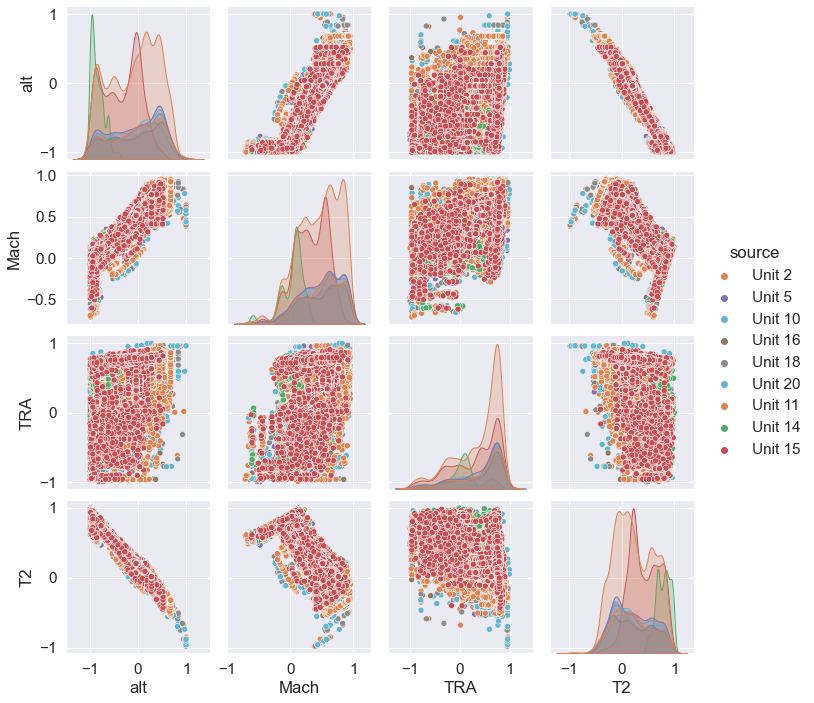

In [10]:
# Sub set of data
dim, size = W_dev.shape[0], 10000
mask_dev = np.sort(np.random.choice(dim, size, replace=False))

df_W_dev = pd.DataFrame(W_dev[mask_dev], columns=W_var)
df_W_dev['source'] = U_dev[mask_dev]
for unit in np.unique(U_dev[mask_dev]):
    mask_u = np.ravel(U_dev[mask_dev] == unit)
    df_W_dev.loc[mask_u, 'source'] = 'Unit ' + str(unit)

dim, size = W_test.shape[0], 10000
mask_test = np.sort(np.random.choice(dim, size, replace=False))

df_W_test = pd.DataFrame(W_test[mask_test], columns=W_var)
df_W_test['source']= U_test[mask_test]
for unit in np.unique(U_test[mask_test]):
    mask_u = np.ravel(U_test[mask_test] == unit)
    df_W_test.loc[mask_u, 'source'] = 'Unit ' + str(unit)

df_W = pd.concat([df_W_dev, df_W_test], ignore_index=True)

# Plot
sns.set(font_scale=1.4)
sns.pairplot(df_W, hue='source', palette=color_dic_unit)

It is worth noting that test **units** 14 has an operation distribution significantly different from those of the development units. Concretely, test unit 14 operates shorter and lower altitude flights than other units. 

Therefore, as shown in the pair plot below, the development dataset contains flight profiles that are underrepresented, i.e., not fully representative of the test conditions for this unit. 

## Compare test units to development units

In the plots below we aggregate all development units to a single data set and display its data under "dev". We then compare this to the three test units to get an impression of the representativeness of the training data. 

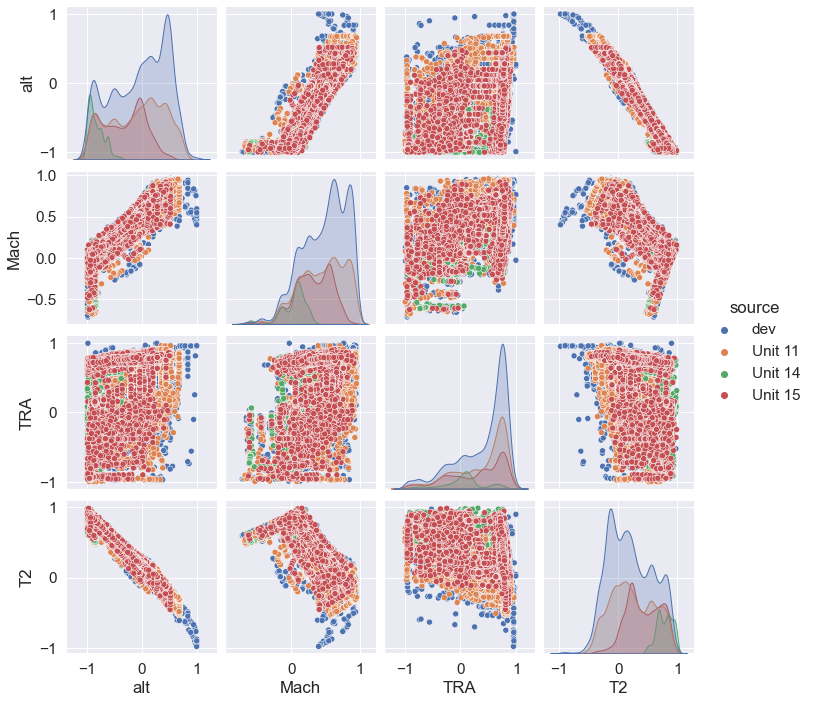

In [11]:
# Sub set of data
dim, size = W_dev.shape[0], 10000
mask_dev = np.sort(np.random.choice(dim, size, replace=False))

df_W_dev = pd.DataFrame(W_dev[mask_dev], columns=W_var)
df_W_dev['source']='dev'

dim, size = W_test.shape[0], 10000
mask_test = np.sort(np.random.choice(dim, size, replace=False))

df_W_test = pd.DataFrame(W_test[mask_test], columns=W_var)
df_W_test['source']= U_test[mask_test]
for unit in np.unique(U_test[mask_test]):
    mask_u = np.ravel(U_test[mask_test] == unit)
    df_W_test.loc[mask_u, 'source'] = 'Unit ' + str(unit)

df_W = pd.concat([df_W_dev, df_W_test], ignore_index=True)

# Plot
sns.set(font_scale=1.4)
sns.pairplot(df_W, hue='source')

## Sensor readings $x_s$

We now create a visualization of the sensor reading profile during one single flight making use of the `plot_variables_iso()` axiliary function.

To subset the data array you can use a `mask` with the criteria

e.g., `mask = np.ravel((U_dev==2) & (C_dev==1))`. --> `Xs_dev[mask,:]`


['T24', 'T30', 'T40', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


<Figure size 432x288 with 0 Axes>

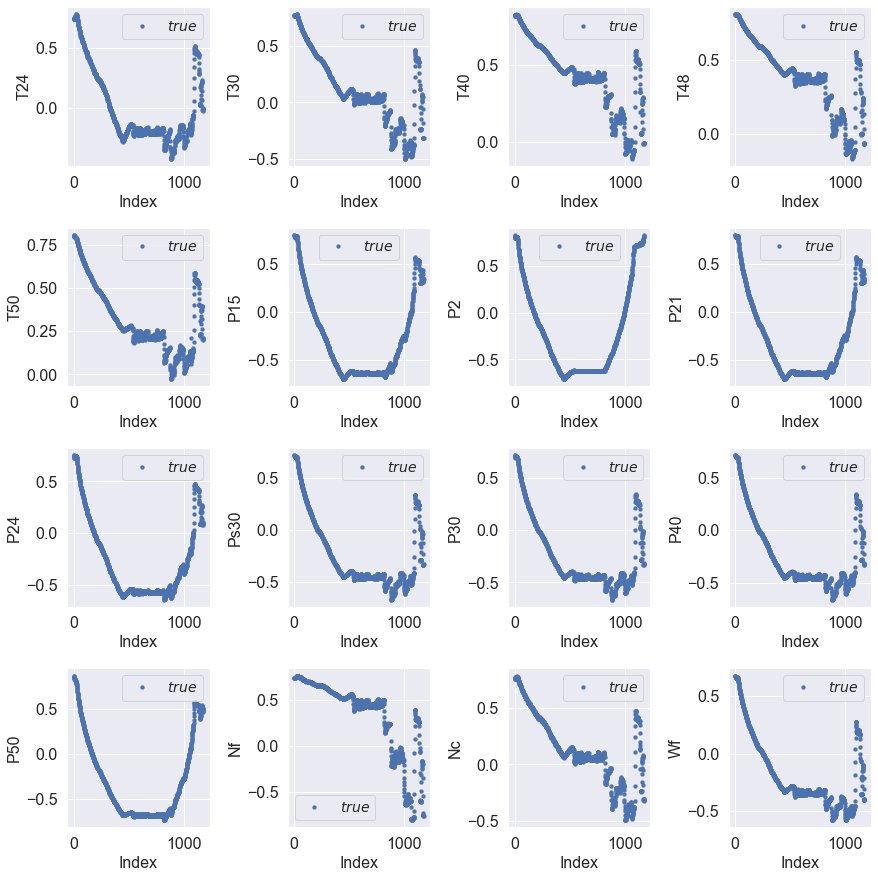

In [12]:
# Set-up
data, data[0] = {}, {}
data[0]['variables'] = Xs_var       # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$true$']
data[0]['ds_name'] = ['true']

# Data to plot
mask = np.ravel((U_dev==2) & (C_dev==1))
data[0]['true'], data[0]['pred'] = {}, {}
data[0]['true']['y'] = Xs_dev[mask,:]
data[0]['true']['x'] = np.arange(data[0]['true']['y'].shape[0])

# Plot
plot_variables_iso(data, figsize=12.5)

## Performance Gap Indicators $\theta$

We now create a visualization of the degradation trajectories provided for (i.e., N=6 development engines and 3 test engines) by plotting the traces of the model parameters $\theta$ vs. the time (e.g., variable value Vs. time). Note that this is possible because we deal with a synthetic data set, where faults were induced, and the degradation was simulated. In a real system, we would have access to the operating conditions $w$ and to the sensor readings $x_s$, but no direct information about $\theta$. The degradation trajectory $\theta$ would then only be estimated indirectly based on the sensor reading. 


['HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod']


<Figure size 432x288 with 0 Axes>

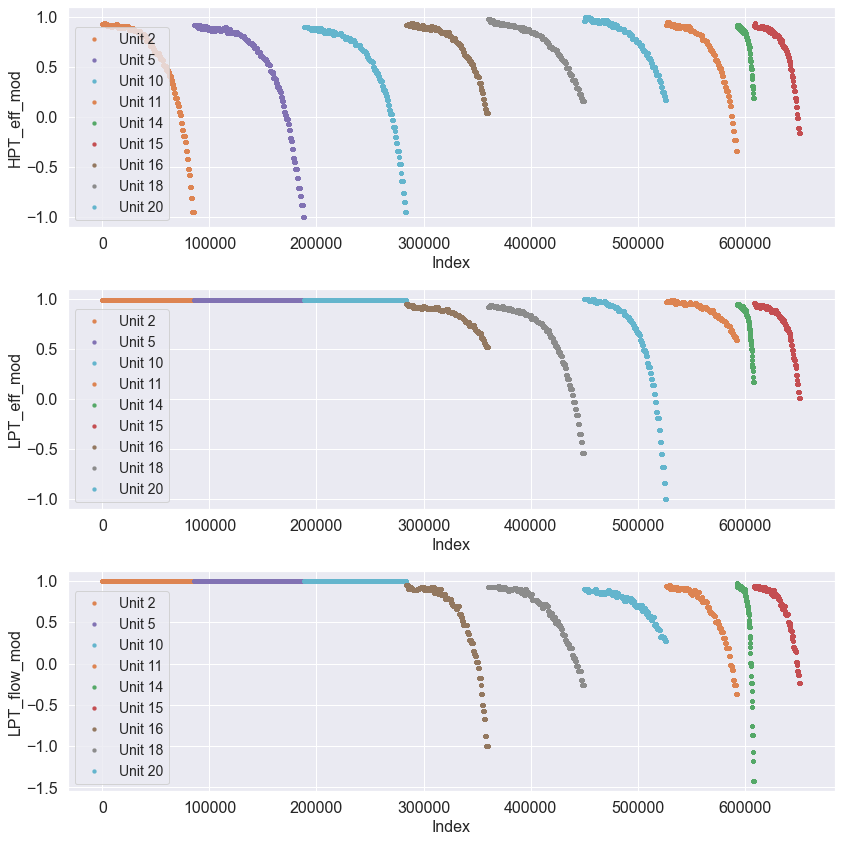

In [13]:
# Set-up
data, data[0] = {}, {}
data[0]['variables'] = T_var       # Variables names
print('')
print(data[0]['variables'])

data[0]['legend'] = ['$true$']
data[0]['ds_name'] = ['true']
data[0]['option'] = 'unit'
#data[0]['xlabel'] = 'Time [cycles]'

# Data to plot
data[0]['true'], data[0]['pred'] = {}, {}
data[0]['true']['y'] = np.concatenate((T_dev, T_test))
data[0]['true']['x'] = np.arange(data[0]['true']['y'].shape[0])
#data[0]['true']['x'] = np.concatenate((C_dev, C_test))
data[0]['true']['units'] = np.concatenate((U_dev, U_test))

# Plot
plot_variables_iso(data, figsize=12)

We can observe that there are two distinctive failure modes are present in the available dataset ($\mathcal{D}$). Units 2, 5, and 10 have failure modes of an $\textit{abnormal}$ high-pressure turbine (HPT) efficiency degradation. Units 16, 18, and 20 are subject to a more complex failure mode that affects the low-pressure turbine (LPT) efficiency and flow in combination with the high-pressure turbine (HPT) efficiency degradation. Test units are subjected to the same complex failure mode. The transition time ($t_{s}$) is dependent on the operating conditions, i.e., flight and degradation profile. It should be noted that although the degradation profiles of individual components show nearly overlapping trajectories, the combined profile (i.e., the profile in three dimensions) is clearly different.

#  Part 1: Data pre-processing

In this part, we will carry out the following pre-processing steps:

* **Step 1.1:** Subsetting the development data to reduce the computational load of this exercise.
* **Step 1.2:** Normalize the development and test datasets between 0 and 1.
* **Step 1.3:** Generation of labeled $D_{L}$ and unlabeled dataset $D_{U}$ by subsetting the development dataset
* **Step 1.4:** Generating training $\mathcal{S}_{T}$ and validation datasets $\mathcal{S}_{V}$

## Step 1.1: Subset development data

As discussed in Part 0, there are two failure modes present in the available dataset ($\mathcal{D}$). Units 2, 5, and 10 have failure modes of an $\textit{abnormal}$ high-pressure turbine (HPT) efficiency degradation. Units 16, 18, and 20 are subject to a more complex failure mode that affects the low-pressure turbine (LPT) efficiency and flows in combination with the high-pressure turbine (HPT) efficiency degradation. Test units are subjected to the same complex failure mode. Therefore, we remove Units 2, 5, and 10 from the available dataset.

Then, we make use of the auxiliary function `extract_units_ds()` to subset the available dataset and create a training dataset with unit 16, 18, and 20 data. We report the shapes of the resulting `np.array()` for all the variables: operative condition `W`, sensor readings `Xs`, performance gap indicators `T`, RUL label `R`, unit number label, `U` and flight cycle number `C`. We denote the resulting variables `{W_, Xs_, T_, R_, C_, U_}_dev`.

In [14]:
# Create subset of development data datasets
id_en_dev = [16, 18, 20]
W_dev = extract_units_ds(id_en_dev, W_dev, U_dev)
Xs_dev = extract_units_ds(id_en_dev, Xs_dev, U_dev)
T_dev = extract_units_ds(id_en_dev, T_dev, U_dev)
R_dev = extract_units_ds(id_en_dev, R_dev, U_dev)
C_dev = extract_units_ds(id_en_dev, C_dev, U_dev)
U_dev = extract_units_ds(id_en_dev, U_dev, U_dev)

print('')
print ("number of examples in the development subset = " + str(Xs_dev.shape[0]))
print ("Xs_dev shape: " + str(Xs_dev.shape))
print ("T_dev shape: " + str(T_dev.shape))
print ("W_dev shape: " + str(W_dev.shape))
print ("U_dev shape: " + str(U_dev.shape))
print ("C_dev shape: " + str(C_dev.shape))

print('')
print ("number of examples in the test subset = " + str(Xs_test.shape[0]))
print ("Xs_test shape: " + str(Xs_test.shape))
print ("T_test shape: " + str(T_test.shape))
print ("W_test shape: " + str(W_test.shape))
print ("U_test shape: " + str(U_test.shape))
print ("C_test shape: " + str(C_test.shape))


number of examples in the development subset = 242418
Xs_dev shape: (242418, 16)
T_dev shape: (242418, 3)
W_dev shape: (242418, 4)
U_dev shape: (242418, 1)
C_dev shape: (242418, 1)

number of examples in the test subset = 125375
Xs_test shape: (125375, 16)
T_test shape: (125375, 3)
W_test shape: (125375, 4)
U_test shape: (125375, 1)
C_test shape: (125375, 1)


While the remaining units have the same failure mode i.e., low-pressure turbine (LPT) efficiency and flow degradation in combination with the high-pressure turbine (HPT) efficiency degradation, we also want to check if the test dataset have similar degradation conditions. To find out we do pairplot of the degradation trajectories in the `T` space.

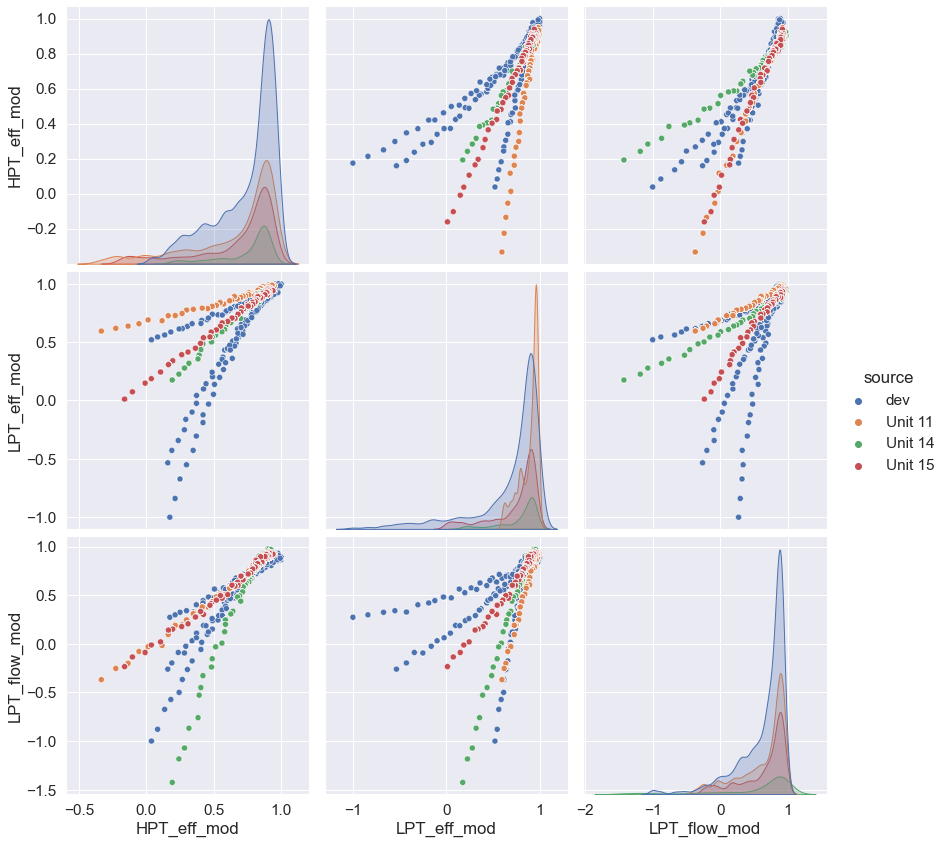

In [15]:
# Sub set of data
dim, size = T_dev.shape[0], 10000
mask_dev = np.random.choice(dim, size, replace=False)

df_T_dev = pd.DataFrame(T_dev[mask_dev, 0:3], columns=T_var[0:3])
df_T_dev['source']='dev'

dim, size = T_test.shape[0], 10000
mask_test = np.sort(np.random.choice(dim, size, replace=False))

df_T_test = pd.DataFrame(T_test[mask_test, 0:3], columns=T_var[0:3])
df_T_test['source']= U_test[mask_test]
for unit in np.unique(U_test[mask_test]):
    mask_u = np.ravel(U_test[mask_test] == unit)
    df_T_test.loc[mask_u, 'source'] = 'Unit ' + str(unit)

df_T = pd.concat([df_T_dev, df_T_test], ignore_index=True)

# Plot
sns.set(font_scale=1.4)
sns.pairplot(df_T, hue='source', height=4)

From the plot above, we can observe that units 11 and 14 have a significantly different degradation profile than the development units (blue dots). In particular, for unit 11, the degradation path defined by `HPT_eff_mod` & `LPT_eff_mod` (top middle or left middle plots) is outside the one observed for the development units. Similarly, for unit 15,  the degradation path defined by `HPT_eff_mod` & `LPT_flow_mod` (top middle or bottom left plot) is also outside the development units. We can also observe that for units 11 and 15 the `HPT_eff_mod` goes beyond the development data. Similarly, for unit 14  `LPT_flow_mod` is also beyond the development data.

However, because we are using a normal state model for anomaly detection, differences in the degradation modes are irrelevant to the ability of our model to detect anomalous behaviour. 
 

## Step 1.2: Normalizing data

A common technique we use in Machine Learning is to normalize our data. It often leads to a better performance because gradient descent converges faster after normalization. In this way, the provided dataset is normalized with a 'max-min' approach to values -1 to 1. While this is common in Machine Learning pipelines, we will renormalize to only positive values, i.e., 0 to 1.

We use the provided auxiliary function `normalize_data()` to renormalize the training and test datasets to only positive values, i.e., 0 to 1. Provide the resulting `np.array()` for all the variables: operative condition `W`, sensor readings `Xs`, and performance gap indicators `T`. We also create a plot to show that, indeed, the variables have been correctly normalized.

In [16]:
# NOTE: Nomalization for anomaly detection is typically done with the labeled dataset and not 
# with the full development dataset
# Sensor readings
Xs_dev, lb, ub = normalize_data(Xs_dev, [], [], max_v=1.0, min_v=0.0)
Xs_test, _, _ = normalize_data(Xs_test, lb, ub, max_v=1.0, min_v=0.0)

# Operative conditions
W_dev, lb, ub = normalize_data(W_dev, [], [], max_v=1.0, min_v=0.0)
W_test, _, _ = normalize_data(W_test, lb, ub, max_v=1.0, min_v=0.0)

# T conditions
T_dev, lb, ub = normalize_data(T_dev, [], [], max_v=1.0, min_v=0.0)
T_test, _, _ = normalize_data(T_test, lb, ub, max_v=1.0, min_v=0.0)

print('')
print ("number of examples in the development subset = " + str(Xs_dev.shape[0]))
print ("Xs_dev shape: " + str(Xs_dev.shape))
print ("W_dev shape: " + str(W_dev.shape))
print ("T_dev shape: " + str(T_dev.shape))

print('')
print ("number of data examples = " + str(Xs_test.shape[0]))
print ("Xs_test shape: " + str(Xs_test.shape))
print ("W_test shape: " + str(W_test.shape))
print ("T_test shape: " + str(T_test.shape))


number of examples in the development subset = 242418
Xs_dev shape: (242418, 16)
W_dev shape: (242418, 4)
T_dev shape: (242418, 3)

number of data examples = 125375
Xs_test shape: (125375, 16)
W_test shape: (125375, 4)
T_test shape: (125375, 3)


## Step 1.3: Generation of a labeled $\mathcal{D}_{L}$ and unlabeled dataset $\mathcal{D}_{U}$ by subsetting the development dataset

As discussed in the solution strategy i.e., section 2.2, we need to model the healthy system. In our problem we assumed that the system health condition (i.e., healthy or faulty) is partially known. In particular we consider the situation where certainty regarding healthy system conditions only available up to a past point in time $t_b$ when the system condition was assessed and confirmed as healthy by maintenance engineers, e.g., during an inspection.  Therefore, in this notebook, we will create a fully labeled dataset ($\mathcal{D}_{L}$) of healthy system conditions (i.e., $h_s^{(i)}=1$) and an unlabeled dataset with unknown health conditions (i.e., $h_s^{(i)}=?$) using the development data. 

Although the information about health state is provided in the dataset, for sysmplicity, we will use a very simple approach to come up with these two sets of data. We assume cycles below or equal to `split_cycle=20` are labeled healthy i.e., $h_s^{(i)}=1$ and the remaining are unlabeled.

We then use the provided auxiliary function `data_subset()` to obtain the labeled $\mathcal{D}_{L}$ and unlabeled dataset $\mathcal{D}_{U}$.  Report the resulting `np.array()` shapes for all the variables: operative condition `W`, sensor readings `Xs`,  unit number `U`,  cycle number `C`, and lagged sensor readings `_Xs`.

In [17]:
U_sel = np.unique(U_dev)
W_lab, W_unl = data_subset(W_dev, U_dev, C_dev, U_sel, split_cycle=20)
Xs_lab, Xs_unl = data_subset(Xs_dev, U_dev, C_dev, U_sel, split_cycle=20)
U_lab, U_unl = data_subset(U_dev, U_dev, C_dev, U_sel, split_cycle=20)
C_lab, C_unl = data_subset(C_dev, U_dev, C_dev, U_sel, split_cycle=20)

print("")
print ("number of labeled examples = " + str(Xs_lab.shape[0]))
print ("W_lab shape: " + str(W_lab.shape))
print ("Xs_lab shape: " + str(Xs_lab.shape))
print ("U_lab shape: " + str(U_lab.shape))
print ("C_lab shape: " + str(C_lab.shape))
print("")
print ("number of unlabeled examples = " + str(Xs_unl.shape[0]))
print ("W_unl shape: " + str(W_unl.shape))
print ("Xs_unl shape: " + str(Xs_unl.shape))
print ("U_unl shape: " + str(U_unl.shape))
print ("C_unl shape: " + str(C_unl.shape))


number of labeled examples = 73824
W_lab shape: (73824, 4)
Xs_lab shape: (73824, 16)
U_lab shape: (73824, 1)
C_lab shape: (73824, 1)

number of unlabeled examples = 168594
W_unl shape: (168594, 4)
Xs_unl shape: (168594, 16)
U_unl shape: (168594, 1)
C_unl shape: (168594, 1)


## Step 1.4: Generating training $\mathcal{S}_{T}$ and validation datasets $\mathcal{S}_{V}$

In [18]:
# Validation as subset of development data
indices = np.arange(Xs_dev.shape[0])
idx_train, idx_val = train_test_split(indices, test_size=0.10, random_state=42, shuffle=True)

W_val = W_dev[np.sort(idx_val)]
Xs_val = Xs_dev[np.sort(idx_val)]         
U_val = U_dev[np.sort(idx_val)]
C_val = C_dev[np.sort(idx_val)]

W_train = W_dev[np.sort(idx_train)]
Xs_train = Xs_dev[np.sort(idx_train)]
U_train = U_dev[np.sort(idx_train)]
C_train = C_dev[np.sort(idx_train)]

# Validation as subset of labeled data
indices = np.arange(Xs_lab.shape[0])
idx_lab, idx_labval = train_test_split(indices, test_size=0.10, random_state=42, shuffle=True)

W_lab_val = W_lab[np.sort(idx_labval)]
Xs_lab_val = Xs_lab[np.sort(idx_labval)]
U_lab_val = U_lab[np.sort(idx_labval)]
C_lab_val = C_lab[np.sort(idx_labval)]

W_lab_train = W_lab[np.sort(idx_lab)]
Xs_lab_train = Xs_lab[np.sort(idx_lab)]
U_lab_train = U_lab[np.sort(idx_lab)]
C_lab_train = C_lab[np.sort(idx_lab)]

# Part 2: Create a reconstruction model (autoencoder)

An autoencoder is any neural network that aims to learn the identity mapping (i.e., it is trained to reconstruct its own input). Therefore, it is a special case of a fully connected neural network consisting of two parts: an encoder ($E$) and a decoder ($D$). The encoder provides an alternative representation of the input ($x= [w, x_s]$) that is denoted as $z$ and referred to as embedding or latent representation. The decoder reconstructs the input (i.e., $\overline{x}$) as closely as possible from its encoded representation $z$. The resulting mapping corresponds to the following structure:

\begin{align}
   \mathcal{G} &= D \circ E\\
   E &= \mathcal{G}^{l_z} \circ \dots \circ \mathcal{G}^1 : \mathbb{R}^n \xrightarrow{} \mathbb{R}^d, x \xrightarrow{}z:x^l\\
   D &= \mathcal{G}^L \circ \dots \circ \mathcal{G}^{l_z+1}: \mathbb{R}^d \xrightarrow{} \mathbb{R}^n, z \xrightarrow{}\overline{x}
\end{align}

where the layer $l_z$ is generally a bottleneck (i.e., $d<n$) and, therefore, $z$ is a compressed representation of the input. Autoencoders are powerful non-linear generalizations of principal component analysis (PCA).

The loss function of autoencoders is: 
\begin{align}
   \ell(x, \overline{x}) &= \frac{1}{2}||x-\mathcal{G}(x)||_2^2
\end{align}

Usually, the encoder and decoder networks are symmetric. However, they can also be asymmetric if the decoder does not reconstruct the same features as input to the encoder. In this section, we will consider the conventional option and will assign $x=[w, x_s]$ as input features and as outputs. 

## Step 2.1: Create a model $\mathbf{\mathcal{G}}$ of the healthy system response i.e. $x_s^{(t)} \in \mathcal{D}_{L}$.

Given `X_{train, val, test}` and `Y_{train, val, test}` datasets, the code below allows the generation and optimization of symmetric and asymmetric autoencoder networks. The network architecture (or search space) is specified in the `config` dictionary. The optimization is carried out by grid search. Each configuration is run `n_runs` times. Each generated model is stored in `MODEL_PATH` as a `.h5` file.

The provided code contains four functions:
1. `create_encoder(input_shape, config)`
2. `create_decoder(input_shape, config)`
3. `create_autoencoder(input_shape, output_shape, config)`
4. `fit_model_ul(MODEL_PATH, X_{train, val, test}, Y_{train, val, test}, config)`
5. `grid_search_ul(MODEL_PATH, X_{train, val, test}, Y_{train, val, test}, config, n_runs)`

In [19]:
def create_encoder(input_shape, config):
    """
    Creates an encoder network with an architecture
    following a geometric series where each hidden layer 
    has half the number of neurons as the previous layer
    inputs:
        input_shape: tuple with input shape
        config: dictionary with nn configuration
    outputs:
        z: np.array with lantent space
        encoder: tf model        
    """ 
    
    # Architecture
    latent_dim = config['n_ls_a']
    cells = [int(config['n_cl_a']*(0.5)**i) for i in range(config['n_hl_a'])]
    
    # Define the inputs
    X_inputs = tf.keras.Input(shape=input_shape, name='encoder_input') 
    X = X_inputs
    
    # Encoding
    for i in range(config['n_hl_a']):
        X = tf.keras.layers.Dense(cells[i],
                                  activation=config['activ'],
                                  kernel_initializer=tf.keras.initializers.glorot_uniform(seed=config['seed']))(X)      
        
    # Latent vector
    z = tf.keras.layers.Dense(latent_dim, name='z')(X)  
      
    # Build encoder from 'X_inputs' to 'z' space
    encoder = tf.keras.Model(X_inputs, z, name='encoder')
    
    return z, encoder

def create_decoder(output_shape, config):
    """
    inputs:
        input_shape: tuple with input shape
        config: dictionary with nn configuration
    outputs:
        outputs: np.array with reconstruction signal
        decoder: tf model        
    """
    
    # Architecture
    latent_dim = config['n_ls_a']
    cells = [int(config['n_cl_a']*(0.5)**i) for i in range(config['n_hl_a'])]
    
    # Define the inputs (from vector to time-dependent input)
    Z_inputs = tf.keras.Input(shape=(latent_dim,))
    X = Z_inputs
    
    # Dencoding      
    for i in reversed(range(config['n_hl_a'])):
        X = tf.keras.layers.Dense(cells[i],                                       
                                  activation=config['activ'],
                                  kernel_initializer=tf.keras.initializers.glorot_uniform(seed=config['seed']))(X)

    # Reconstructed input
    outputs = tf.keras.layers.Dense(output_shape[-1])(X)

    # Build decoder model
    decoder = tf.keras.Model(Z_inputs, outputs, name='decoder')

    return outputs, decoder

def create_autoencoder(input_shape, output_shape, config):
    """
    inputs:
        input_shape: tuple with input shape
        output_shape: tuple with output shape (in case it is an asymetric AE)
        config: dictionary with nn configuration
    outputs:
        autoencoder, encoder, decoder: tf models        
    """
    
    # Define the inputs
    X_inputs = tf.keras.Input(shape=input_shape) 
    
    # Create encoder
    z, encoder = create_encoder(input_shape, config) 
    
    # Create decoder
    outputs, decoder = create_decoder(output_shape, config)
   
    # Create autoencoder
    X_hat = decoder(encoder(X_inputs))
    autoencoder = tf.keras.Model(X_inputs, X_hat, name='ae')    
                   
    # Optimiser set-up
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

    # Compilation
    autoencoder.compile(optimizer=opt, loss="mean_squared_error")
    
    return autoencoder, encoder, decoder

def fit_model_ul(OUTFOLDER, 
                   X_train, Y_train, 
                   X_val, Y_val,
                   X_test, Y_test,
                   config, label, generate=True):
    """
    Creates and trains a NN with unsupervised learning strategy: 
    define model shapes, create model, fit model, plot training loss and save model
    inputs:
        OUTFOLDER: path to storage or model folder
        X_{train, val, test}: np.array with train, val and test input features.
        Y_{train, val, test}: np.array with train, val and test target features.
        config: dictionary with NN configuration (i.e. hyperparameters).
        label: str with model name for storage or loading
        generate_a: boolean with load or run.
    outputs:
        loss_val: np.array with loss in val dataset
        Y_hat_{train, val, test}: np.array with train, val and test output predictions.       
    """
    if generate:
        # Set-up I - 
        seed = config['seed']
        os.environ['PYTHONHASHSEED'] = '0'
        np.random.seed(seed)
        tf.keras.backend.clear_session()        

        # Set-up II - Shapes 
        input_shape = X_train.shape[1:]
        output_shape = Y_train.shape[1:]
        
        # Create autoencoder model
        autoencoder, encoder, decoder = create_autoencoder(input_shape, output_shape, config)
        
        # Callbacks
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=config['patience'], 
                                                      restore_best_weights = True)
        
        # Report model summary
        autoencoder.summary()
        
        # Fit model       
        history = autoencoder.fit(X_train, Y_train,
                                  batch_size=config['batch_size'], 
                                  epochs=config['epochs'], 
                                  callbacks=[early_stop],
                                  validation_data=(X_val, Y_val),
                                  verbose=0)   
        
        # Summarize history for loss
        plt.clf()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        # Save encoder model
        encoder.save(OUTFOLDER + 'model_E_' + str(label) + '.h5')
        print('')
        print("Saved Encoder model to disk")
        
        # Save auteoencoder model
        autoencoder.save(OUTFOLDER + 'model_AE_' + str(label) + '.h5')
        print('')
        print("Saved AutoEncoder model to disk")
        
        # Save decoder model
        decoder.save(OUTFOLDER + 'model_D_' + str(label) + '.h5')
        print('')
        print("Saved Decoder model to disk")     
        
    else:
        # Autoencoder
        autoencoder= tf.keras.models.load_model(OUTFOLDER + 'model_AE_' + str(label) + '.h5')
        print('')
        print("Loaded Autoencoder model from disk")
        
        # Report model summary
        autoencoder.summary()
        
        # Compilation
        autoencoder.compile(optimizer='Adam', loss="mean_squared_error")  
        
    # Evaluate model      
    loss_val = autoencoder.evaluate(x=X_val, y=Y_val)
    
    # Predict outputs
    Y_hat_train = autoencoder.predict(x=X_train)
    Y_hat_val = autoencoder.predict(x=X_val)
    Y_hat_test = autoencoder.predict(x=X_test)

    return loss_val, Y_hat_train, Y_hat_val, Y_hat_test

def grid_search_ul(MODEL_PATH,
                   X_train, Y_train, 
                   X_val, Y_val,
                   X_test, Y_test, 
                   params, n_runs, varInput, generate=True):
    """
    Performs a grid search in a NN with unsupervised learning strategy: 
    define model shapes, create model, fit model, plot training loss and save model
    inputs:
        MODEL_PATH: path to storage or model folder.
        X_{train, val, test}: np.array with train, val and test input features.
        params: dictionary, NN possible configurations.
        n_runs: int, each configuration is performed n_runs times.
        varInput: str with mapping label.
        generate_a: boolean with load or run.
    outputs:
        df: storage dataframe.
        log_label: list of unique model labels.
    """
    # Set-up
    df = pd.DataFrame()
    log_loss_val, log_label, log_df = [], [], []
    keys, values = zip(*params.items())

    for kk, bundle in enumerate(product(*values)):        # Varing architectures
        
        # Architecture [kk]
        config = dict(zip(keys, bundle))

        for jj in range(n_runs):                         # Check reproducibility - n runs             
            df_k = pd.DataFrame(config, index=[0])
           
            # Define simulation label
            label =  varInput + '_h_a_' + str(kk) + '_run_' + str(jj)
            print('')
            print('Simulation:', label)

            # Fit NN model
            time_start = time.time()
            loss_val, Y_hat_train, Y_hat_val, Y_hat_test =\
            fit_model_ul(MODEL_PATH,
                           X_train, Y_train, 
                           X_val, Y_val,
                           X_test, Y_test,
                           config, label, generate=generate)
            
            # Store results
            log_loss_val.append(loss_val)
            log_label.append(label)

            # Log architecture/run/results as pandas DataFrame
            df_k['run']= jj
            df_k['RMSE-Ts'] = np.round(np.sqrt(np.mean((Y_hat_test - Y_test)**2)), 3)
            df_k['RMSE-Va'] = np.round(np.sqrt(np.mean((Y_hat_val - Y_val)**2)), 3)
            df_k['RMSE-Tr'] = np.round(np.sqrt(np.mean((Y_hat_train - Y_train)**2)), 3)
            df_k['Time[min]'] = np.round((time.time()-time_start)/60, 2)            
            log_df.append(df_k)
            df = pd.concat(log_df, ignore_index=True)

            print('')
            print(df.to_string())

            # Write solutions to 
            df.to_csv(MODEL_PATH + 'Training_US_' +  varInput + '.csv')

    return df, log_label, log_loss_val

**Define newtwork architecture**

In [20]:
# Network architecture
params = {"activ": ['relu'],      # Activation - h1 = ['tanh', 'relu']
          "n_hl_a": [3],          # Number of hidden layers - h2 = [1, 2, 3]
          "n_cl_a": [50],         # Initial number of channels (halves for each hidden layer) - h3 = [10, 20, 50]   
          "n_ls_a": [5],          # Latent space z dimensions - h5 = [6, 8, 10, 12, 14, 16, 18]  
          "batch_size": [128],    # Batch size autoencoder - h6 = [64, 128, 512, 1024]    
          "epochs": [50],         # Epochs - h7 (on demand)
          "seed": [229],          # Seed number
          "patience": [15]
           }

# Number of runs per NN architecture
n_runs = 5 

**Define the inputs and targets variables for training, validation and test i.e., `X_train`, `Y_train`,  `X_val`, `Y_val` `X_test` and `Y_test`.**

In [21]:
# Inputs
X_train = np.concatenate((W_lab_train, Xs_lab_train), axis=-1)
X_val = np.concatenate((W_lab_val, Xs_lab_val), axis=-1)
X_test = np.concatenate((W_test, Xs_test), axis=-1)

# Targets
Y_train = X_train
Y_val = X_val
Y_test = X_test

# Model tag 
input_s = 'W_Xs'      
target_s = 'W_Xs' 
var_input = input_s + '-' + target_s
var_names = W_var + Xs_var


# renamce for later (part 4)
X_train_2, X_val_2, X_test_2, var_names_2 = X_train, X_val, X_test, var_names

**Fit model according to the defined inputs and targets variables** 


Simulation: W_Xs-W_Xs_h_a_0_run_0
Model: "ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 encoder (Functional)        (None, 5)                 2702      
                                                                 
 decoder (Functional)        (None, 20)                2717      
                                                                 
Total params: 5,419
Trainable params: 5,419
Non-trainable params: 0
_________________________________________________________________


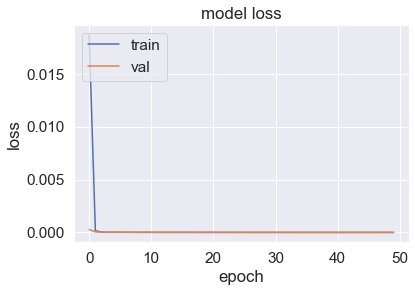


Saved Encoder model to disk

Saved AutoEncoder model to disk

Saved Decoder model to disk
231/231 [==============================] - 0s 580us/step - loss: 4.1856e-06

  activ  n_hl_a  n_cl_a  n_ls_a  batch_size  epochs  seed  patience  run  RMSE-Ts  RMSE-Va  RMSE-Tr  Time[min]
0  relu       3      50       5         128      50   229        15    0    0.006    0.002    0.002       0.43

Simulation: W_Xs-W_Xs_h_a_0_run_1
Model: "ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 encoder (Functional)        (None, 5)                 2702      
                                                                 
 decoder (Functional)        (None, 20)                2717      
                                                                 
Total params: 5,419
Trainable param

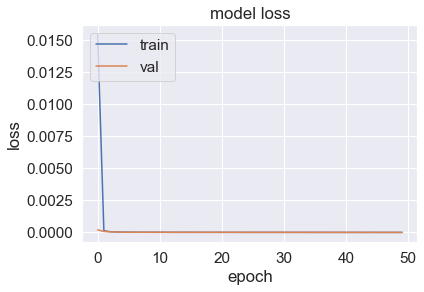


Saved Encoder model to disk

Saved AutoEncoder model to disk

Saved Decoder model to disk
231/231 [==============================] - 0s 568us/step - loss: 6.7004e-06

  activ  n_hl_a  n_cl_a  n_ls_a  batch_size  epochs  seed  patience  run  RMSE-Ts  RMSE-Va  RMSE-Tr  Time[min]
0  relu       3      50       5         128      50   229        15    0    0.006    0.002    0.002       0.43
1  relu       3      50       5         128      50   229        15    1    0.006    0.003    0.003       0.43

Simulation: W_Xs-W_Xs_h_a_0_run_2
Model: "ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 encoder (Functional)        (None, 5)                 2702      
                                                                 
 decoder (Functional)        (None, 20)                2

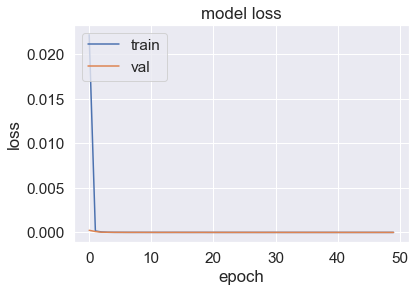


Saved Encoder model to disk

Saved AutoEncoder model to disk

Saved Decoder model to disk
231/231 [==============================] - 0s 551us/step - loss: 3.9776e-06

  activ  n_hl_a  n_cl_a  n_ls_a  batch_size  epochs  seed  patience  run  RMSE-Ts  RMSE-Va  RMSE-Tr  Time[min]
0  relu       3      50       5         128      50   229        15    0    0.006    0.002    0.002       0.43
1  relu       3      50       5         128      50   229        15    1    0.006    0.003    0.003       0.43
2  relu       3      50       5         128      50   229        15    2    0.006    0.002    0.002       0.43

Simulation: W_Xs-W_Xs_h_a_0_run_3
Model: "ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 encoder (Functional)        (None, 5)                 2702      
           

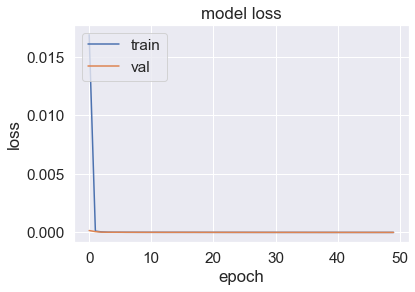


Saved Encoder model to disk

Saved AutoEncoder model to disk

Saved Decoder model to disk
231/231 [==============================] - 0s 744us/step - loss: 5.5686e-06

  activ  n_hl_a  n_cl_a  n_ls_a  batch_size  epochs  seed  patience  run  RMSE-Ts  RMSE-Va  RMSE-Tr  Time[min]
0  relu       3      50       5         128      50   229        15    0    0.006    0.002    0.002       0.43
1  relu       3      50       5         128      50   229        15    1    0.006    0.003    0.003       0.43
2  relu       3      50       5         128      50   229        15    2    0.006    0.002    0.002       0.43
3  relu       3      50       5         128      50   229        15    3    0.005    0.002    0.002       0.50

Simulation: W_Xs-W_Xs_h_a_0_run_4
Model: "ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                

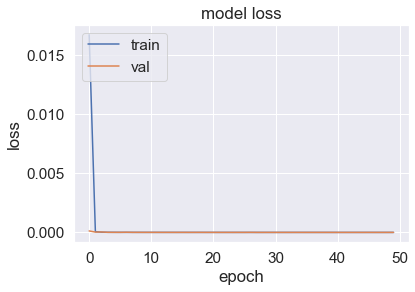


Saved Encoder model to disk

Saved AutoEncoder model to disk

Saved Decoder model to disk
231/231 [==============================] - 0s 741us/step - loss: 5.3724e-06

  activ  n_hl_a  n_cl_a  n_ls_a  batch_size  epochs  seed  patience  run  RMSE-Ts  RMSE-Va  RMSE-Tr  Time[min]
0  relu       3      50       5         128      50   229        15    0    0.006    0.002    0.002       0.43
1  relu       3      50       5         128      50   229        15    1    0.006    0.003    0.003       0.43
2  relu       3      50       5         128      50   229        15    2    0.006    0.002    0.002       0.43
3  relu       3      50       5         128      50   229        15    3    0.005    0.002    0.002       0.50
4  relu       3      50       5         128      50   229        15    4    0.006    0.002    0.002       0.60


In [22]:
# Working folder: storage
ROOT_PATH_2 = 'models/01-AE-MLP'
MODEL_PATH_2 = ROOT_PATH_2  + '/' + strftime("%Y-%m-%d", gmtime()) + '/'
if not os.path.exists(MODEL_PATH_2):
    os.makedirs(MODEL_PATH_2)

# Fit model
df, log_label_2, log_loss_val = grid_search_ul(MODEL_PATH_2,
                                X_train, Y_train, 
                                X_val, Y_val,
                                X_test, Y_test,
                                params, n_runs, var_input, 
                                generate=True)

## Step 2.2: Compute model predictions on labeled $\mathcal{D}_{L}$ and test $\mathcal{D}_{T_*}$ datasets 

Once $\mathcal{G}_{AE}$ is learnt with $[w^{(t)}, x_s^{(t)}] \in \mathcal{D}_{L}$ then it can be used to compute predictions i.e., sensor readings ($x_{s*}^{(t)}$) given new operative conditions and sensor readings i.e.,  $[w_*^{(t)}, x_{s*}^{(t)}] \in \{\mathcal{D}_{U}, \mathcal{D}_{T_*}\}$. 

\begin{equation}
  {\hat{y}}^{(t)} = \mathcal{G}_{AE}(w^{(t)}, x_s^{(t)})  \quad with  \quad {\hat{y}}^{(t)} = [\hat{w}^{(t)}, \hat{x}_s^{(t)}] 
\end{equation}

We then compute predictions of the $\mathcal{G}_{AE}$ model on labeled (training and validation) and test datasets i.e., `Y_hat_train`, `Y_hat_val` and `Y_hat_test`.

In [23]:
# Select model with best loss on validation set!!
log_loss_val = np.array(log_loss_val)
mask = np.ravel(log_loss_val==min(log_loss_val))
label = list(itertools.compress(log_label_2, mask))[0]

model = tf.keras.models.load_model(MODEL_PATH_2 + 'model_AE_' + str(label) + '.h5')
Y_hat_train = model.predict(x=X_train)
Y_hat_val = model.predict(x=X_val)
Y_hat_test = model.predict(x=X_test)

**Labeled dataset**

We plot the true and predicted values for a subset of the labeled dataset (for instance, the last 1000 samples) to check how good the $\mathcal{G}$ model is on healthy data. We can see below that there is a good alligment between `true` and `pred` and (as it will become clearer in the next section) the prediction error is small.


['alt', 'Mach', 'TRA', 'T2', 'T24', 'T30', 'T40', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


<Figure size 432x288 with 0 Axes>

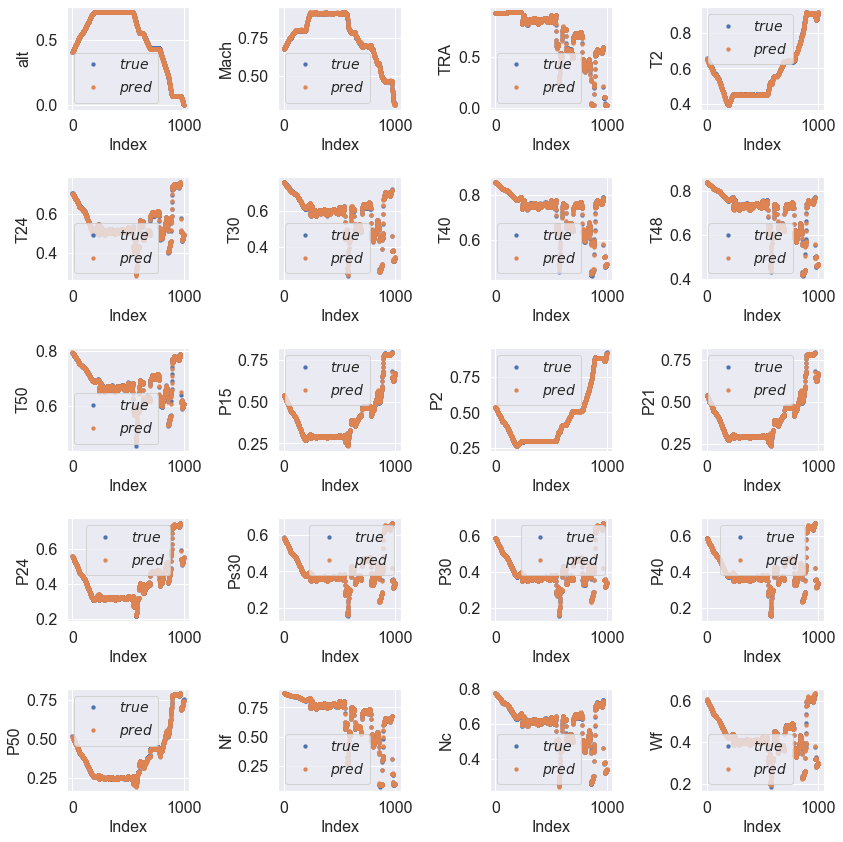

In [24]:
dim1=1000

data, data[0] = {}, {}
data[0]['variables'] = var_names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$true$', '$pred$']
data[0]['ds_name'] = ['true', 'pred']
data[0]['color'] = ['C0', 'C1']

# Data to plot
# True
data[0]['true'] = {}
data[0]['true']['y'] = Y_train[-dim1:,:]
data[0]['true']['x'] = np.arange(data[0]['true']['y'].shape[0])

# Pred
data[0]['pred'] = {}
data[0]['pred']['y'] = Y_hat_train[-dim1:,:]
data[0]['pred']['x'] = np.arange(data[0]['pred']['y'].shape[0])

# Plot
plot_variables_iso(data, figsize=12)

**Test dataset**

We also plot the true and predicted values for subset of the test dataset (for instance the last 1000 samples). We can observe that the reconstruction error of variables `T40`, `T48`, `T50` and `Wf` is particularly high indicating the presence of a degradation on the test data.


['alt', 'Mach', 'TRA', 'T2', 'T24', 'T30', 'T40', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


<Figure size 432x288 with 0 Axes>

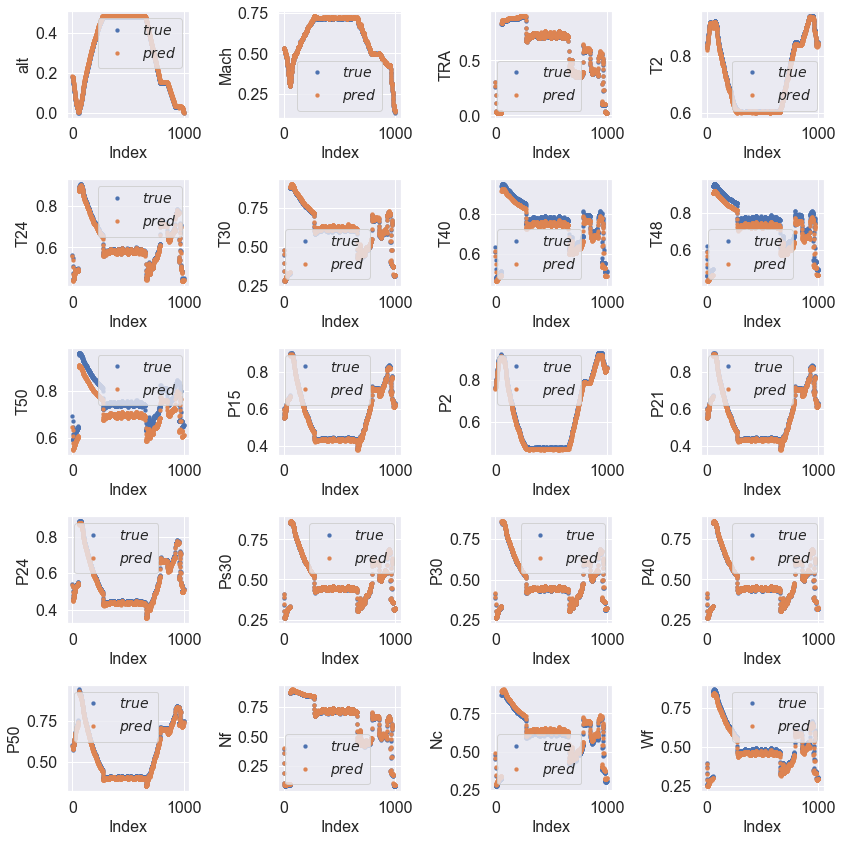

In [25]:
dim1=1000

data, data[0] = {}, {}
data[0]['variables'] = var_names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$true$', '$pred$']
data[0]['ds_name'] = ['true', 'pred']
data[0]['color'] = ['C0', 'C1']

# Data to plot
data[0]['true'] = {}
data[0]['true']['y'] = Y_test[-dim1:,:]
data[0]['true']['x'] = np.arange(data[0]['true']['y'].shape[0])

data[0]['pred'] = {}
data[0]['pred']['y'] = Y_hat_test[-dim1:,:]
data[0]['pred']['x'] = np.arange(data[0]['pred']['y'].shape[0])

# Plot
plot_variables_iso(data, figsize=12)

## Step 2.3: Compute residuals between sensor readings $x_s^{(t)}$ and model predictions $\hat{x}_s^{(t)}$ on labeled ($\mathcal{D}_{L}$)  and test $\mathcal{D}_{T_*}$ datasets


\begin{equation} 
  \delta^{(t)}= {x_s}^{(t)} - {\hat{x}_s}^{(t)} 
\end{equation}

In [26]:
delta_lab_train = Y_train-Y_hat_train
delta_lab_val = Y_val-Y_hat_val
delta_test = Y_test-Y_hat_test

print('Matrix 2-norm test dataset:', round(np.linalg.norm(delta_test, ord=2),3))
print('Matrix Frobenius norm test dataset:', round(np.linalg.norm(delta_test, ord='fro'),3))
print('')
print('Matrix 2-norm train dataset:', round(np.linalg.norm(delta_lab_train, ord=2),3))
print('Matrix Frobenius norm train dataset:', round(np.linalg.norm(delta_lab_train, ord='fro'),3))

Matrix 2-norm test dataset: 8.797
Matrix Frobenius norm test dataset: 9.329

Matrix 2-norm train dataset: 1.171
Matrix Frobenius norm train dataset: 2.331


**Labeled dataset**

We plot the predicted residuals for the labeled dataset as a function of the datapoint index $j$


['alt', 'Mach', 'TRA', 'T2', 'T24', 'T30', 'T40', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


<Figure size 432x288 with 0 Axes>

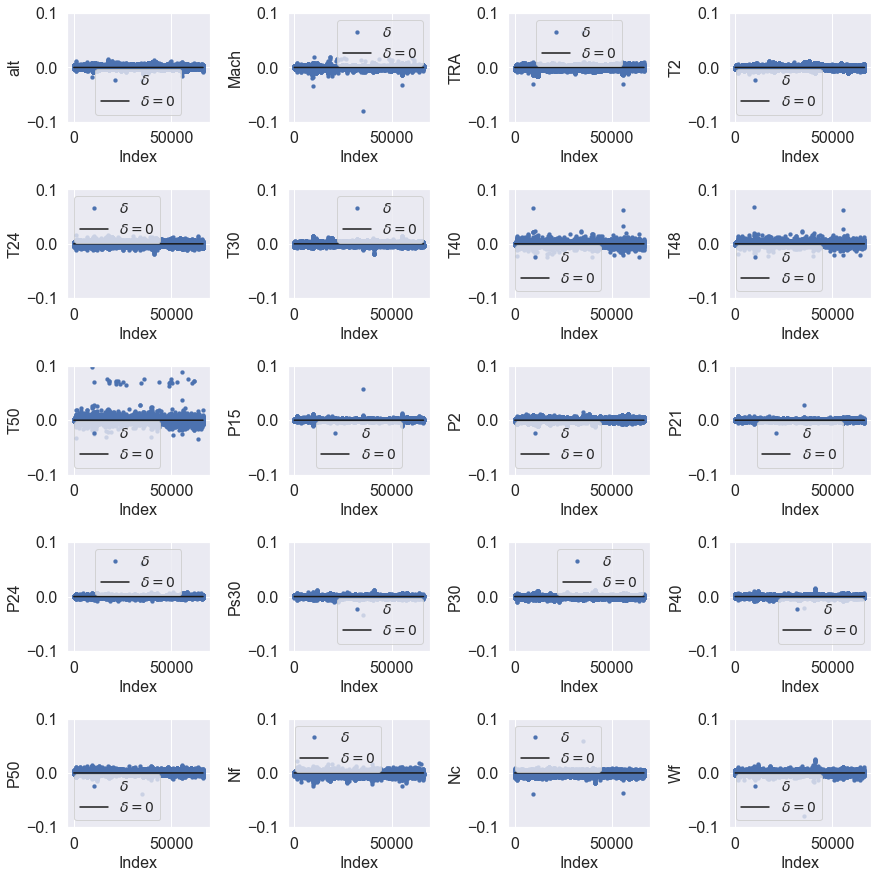

In [27]:
data, data[0] = {}, {}
data[0]['variables'] = var_names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$\delta$', '$\delta=0$']
data[0]['ds_name'] = ['delta', 'zero']
data[0]['color'] = ['C0', 'C1']

# Data to plot
# delta = True - pred
data[0]['delta'] = {}
data[0]['delta']['y'] = delta_lab_train
data[0]['delta']['x'] = np.arange(data[0]['delta']['y'].shape[0])

# Zero line
data[0]['zero'] = {}
data[0]['zero']['y'] = np.zeros(shape=data[0]['delta']['y'].shape)
data[0]['zero']['x'] = np.arange(data[0]['zero']['y'].shape[0])
data[0]['zero']['marker'] = 'k-'

# Plot limits
y_min = -0.1              # Min y
y_max = 0.1               # Max y

# Plot
plot_variables_iso(data, figsize=12.5, y_min=y_min, y_max=y_max)

**Test dataset**

We also plot the delta for the test dataset as a function of the datapoint index $j$


['alt', 'Mach', 'TRA', 'T2', 'T24', 'T30', 'T40', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


<Figure size 432x288 with 0 Axes>

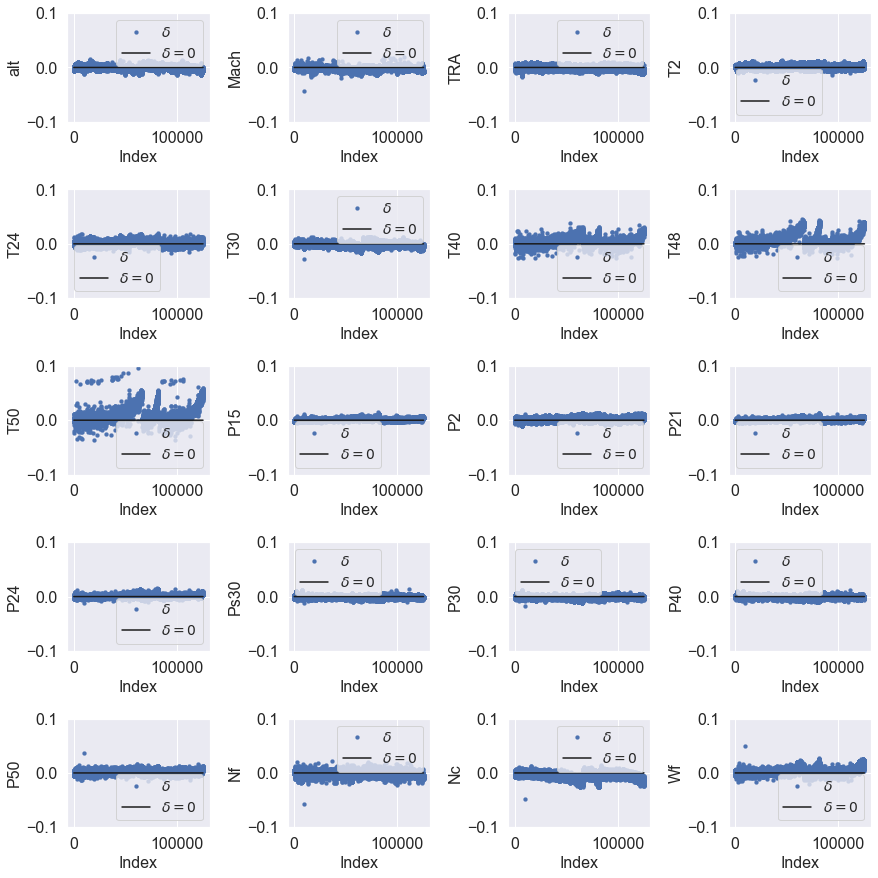

In [28]:
data, data[0] = {}, {}
data[0]['variables'] = var_names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$\delta$', '$\delta=0$']
data[0]['ds_name'] = ['delta', 'zero']
data[0]['color'] = ['C0', 'C1']

# Data to plot
data[0]['delta'] = {}
data[0]['delta']['y'] = delta_test
data[0]['delta']['x'] = np.arange(data[0]['delta']['y'].shape[0])
#data[0]['delta']['units'] = U_test

data[0]['zero'] = {}
data[0]['zero']['y'] = np.zeros(shape=data[0]['delta']['y'].shape)
data[0]['zero']['x'] = np.arange(data[0]['zero']['y'].shape[0])
data[0]['zero']['marker'] = 'k-'

# Plot limits
y_min = -0.1              # Min y
y_max = 0.1             # Max y

# Plot
plot_variables_iso(data, figsize=12.5, y_min=y_min, y_max=y_max)

## Step 2.4:  Identify features with larger deviations on the test set $\mathcal{D}_{T_*}$ 


The system model $\mathcal{G}$ allows the computation of the expected $[\hat{w}^{(t)}, \hat{x}_{s*}^{(t)}]$signal values under the training input conditions (i.e., $w$). The output of the $\mathcal{G}$ i.e., $\hat{x}_{s*}^{(t)}$ will deviate from the input value $x_{s*}$ when the inner relationship of a new data point $x_{s*}^{(j)} \in \{\mathcal{D}_{U},\mathcal{D_{T}}\}$ does not correspond to the one observed in the training set $S_{T}$. Therefore, we compute the absolute deviation that each component of the reconstructed signals has (i.e., $|\delta^{(t)}_k|$) relative to the error observed in the validation dataset $S_V$ (i.e., healthy operation conditions).

\begin{equation} 
  d_I(x_k^{(j)};\nu_k) =  \frac{|\delta_k^{(j)}|}{\nu_k}
\end{equation}

where $\nu$ corresponds to a normalizing threshold given by the 99.9\% percentile of the absolute error of the prediction of $F$ in the validation set $S_{V}$


\begin{equation}
  \nu_k = P_{99.9}\big(\{|\delta_k^{(i)}| \; | \; x_k^{(i)}\in S_V\}\big) % \; \forall
\end{equation}

$d_I(x_k^{(j)};\nu)$ is an unbounded measure of similarity between the signal value predicted by $\mathcal{G}$ and the expected or true signal value.

We now report the signals that have the largest aggregated $d_I(x_k^{(j)};\nu)$ on the test dataset.

In [29]:
def similarity(true, pred, delta_ref):
    '''
    This function implements $d_I(x_k^{(j)};\nu)$. This is, the unbounded similary score
    or the absolute deviation that each component of two vertors "true" and 'pred' 
    nomalized to a reference error vector "delta_ref"
    '''
    
    # Set-up
    gamma = 1.0

    # Define a detection threshold based on the quantile of the validation set
    abs_delta_ref = np.abs(delta_ref)
    threshold = gamma*np.percentile(abs_delta_ref, 99.9, axis=0)

    # Compute metric
    rel_abs_delta = np.abs(true - pred)/threshold
    
    return rel_abs_delta


### Fault isolation?
The reconstruction errors are spread over all output variables. Can we assign a physical meaning to these residuals? Is there a relation between the magnitude of the residuals and the appearance of a fault in the respective sensor? to answer this we compute the mean absolute residuals over the entire test data for each output variable. 

In [30]:
def evaluate_isolation(true, pred, delta_ref, numSignals = 10):
      
    # Similarity evaluation
    rel_abs_delta = similarity(true, pred, delta_ref)
    
    # Isolation
    mean_rel_abs_delta = np.mean(rel_abs_delta, axis=0)
    #mean_rel_abs_delta = np.sum(rel_abs_delta, axis=0)
    delta_sorted = sorted(mean_rel_abs_delta, reverse = True)[0:numSignals]
    idx_top = np.argsort(mean_rel_abs_delta)[::-1][:numSignals]    

    return rel_abs_delta, delta_sorted, idx_top

def report_isolation(delta_sorted, idx_top, varname):
    isolation = [varname[x] for x in idx_top]
    dict_isolation = {key: value for (key, value) in zip(isolation, delta_sorted)}
    for key in dict_isolation:
        print(key, ' : ', np.round(dict_isolation[key],3))

In [31]:
DI_test, delta_sorted, idx_top = evaluate_isolation(Y_test, Y_hat_test, delta_lab_val)
report_isolation(delta_sorted, idx_top, var_names)

T48  :  0.736
T50  :  0.513
Nc  :  0.493
T40  :  0.445
Wf  :  0.308
P21  :  0.3
P15  :  0.298
P24  :  0.297
T24  :  0.285
T30  :  0.283


In addition, we plot the time evolution of the residuals for the 9 variables with the highest mean value. The plots demonstrate the fact that large residuals cannot necessarily be interpreted as faults in the respective sensors. For example, some of the largest residuals are observed in variables that are fixed as operative conditions $w$, like the TRA and the altitude. This "leakage" or "smearing" of the residuals, which redistribute among the outputs, leads to difficulty in interpreting them physically and thus does not allow for fault isolation. 


['T48', 'T50', 'Nc', 'T40', 'Wf', 'P21', 'P15', 'P24', 'T24']


<Figure size 432x288 with 0 Axes>

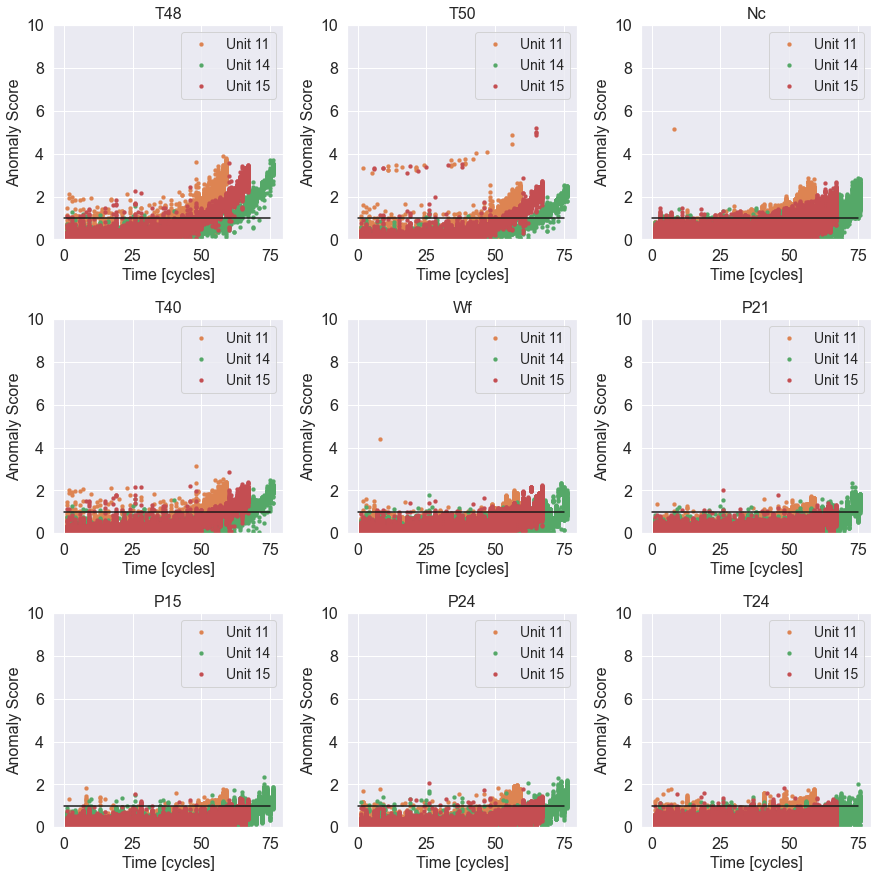

In [32]:
subset = idx_top[0:9]
data, data[0] = {}, {}
data[0]['variables'] = [var_names[x] for x in subset]     # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['ds_name'] = ['test', 'threshold']
data[0]['ylabel'] ='score'
data[0]['xlabel'] ='Time [cycles]'

# Data to plot
data[0]['test'] = {}
data[0]['test']['y'] = DI_test[:,subset] 
data[0]['test']['x'] = C_test
data[0]['test']['units'] = U_test

thrs_test = np.ones(np.max(C_test)).reshape(-1,1)
data[0]['threshold'] = {}
data[0]['threshold']['y'] = np.repeat(thrs_test, len(subset), axis=1)
data[0]['threshold']['x'] = np.arange(data[0]['threshold']['y'].shape[0])
data[0]['threshold']['marker'] = 'k-'

# Plot limits
y_min = 0.0           # Min y
y_max = 10.0          # Max y

# Plot
plot_variables_iso(data, figsize=12.5, y_min=y_min, y_max=y_max)

It is worth noting that ${d_I}(x_k^{(j)};\nu_k)$ are obtained at each point in time at which a new sample is available. Therefore, unit-specific pointwise estimations can show high variability within a flight cycle. In order to mitigate this effect, we also define the average $d_I$ at cycle $c$ in unit $u$ (i.e., ${d_I}_{u}^{[c]}$), which is defined as follows: 

\begin{align}
	 {d_I}_{u}^{[c]} &= \frac{1}{m_u^{[c]}} \sum_{j=1}^{m_u^{[c]}}  {d_I}_{u}(x_k^{(j)};\nu_k)
\end{align}

where $m_u^{[c]}$ is the length of the flight cycle $c$ for the \textit{u-th} unit, which is formally defined using the indicator function, i.e., $\mathbf{1}\{.\}$, as:

\begin{align}
m_u^{[c]}=\sum_{j=1}^{m_*} \mathbf{1}\{U^{(j)} = u \; \wedge \; C^{(j)}=c\}
\end{align}

We can compute the with the function  `mean_per_cycle()` 

In [33]:
def mean_per_cycle(data, units, cycles):
    """
    Computes the mean i.e., mu, and the standard deviation sigma of 'delta' per cycle and unit
    
    """
    # Set-up
    log_means, log_units, log_cycles = [], [], []
    
    # Loop over units
    for unit in np.unique(units):
        mask_u = np.ravel(units == unit)
        data_unit = data[mask_u,:]
        C_unit = cycles[mask_u,:]
        
        # and then loop within unit's cycles
        for cycle in np.unique(C_unit):
            mask_c = np.ravel(C_unit == cycle)
            data_unit_cycle = data_unit[mask_c,:]
            log_means.append(np.mean(data_unit_cycle, axis=0))
            log_cycles.append(cycle)
            log_units.append(unit)
            
    return np.array(log_means), np.array(log_cycles), np.array(log_units)

In [34]:
di_test, c_test, u_test = mean_per_cycle(DI_test, U_test, C_test)


['T48', 'T50', 'Nc', 'T40', 'Wf', 'P21', 'P15', 'P24', 'T24']


<Figure size 432x288 with 0 Axes>

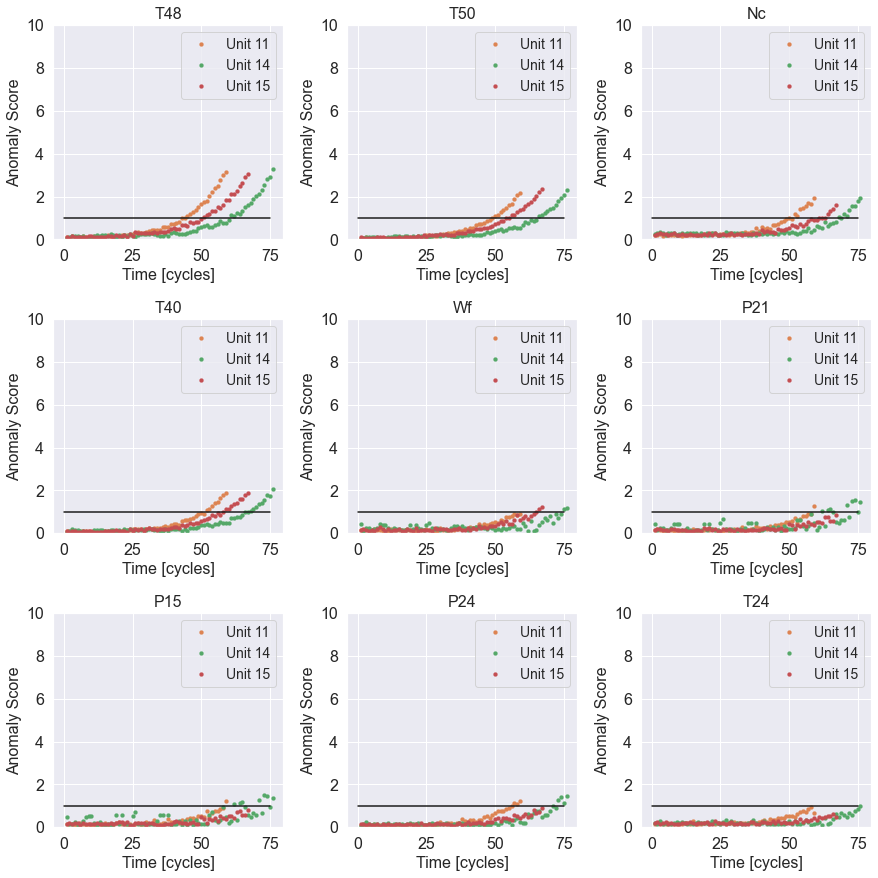

In [35]:
subset = idx_top[0:9]
data, data[0] = {}, {}
data[0]['variables'] = [var_names[x] for x in subset]     # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['ds_name'] = ['test', 'threshold']
data[0]['ylabel'] ='score'
data[0]['xlabel'] ='Time [cycles]'

# Data to plot
data[0]['test'] = {}
data[0]['test']['y'] = di_test[:,subset] 
data[0]['test']['x'] = c_test
data[0]['test']['units'] = u_test

thrs_test = np.ones(np.max(c_test)).reshape(-1,1)
data[0]['threshold'] = {}
data[0]['threshold']['y'] = np.repeat(thrs_test, len(subset), axis=1)
data[0]['threshold']['x'] = np.arange(data[0]['threshold']['y'].shape[0])
data[0]['threshold']['marker'] = 'k-'

# Plot limits
y_min = 0.0           # Min y
y_max = 10.0          # Max y

# Plot
plot_variables_iso(data, figsize=12.5, y_min=y_min, y_max=y_max)

It is worth noting that at also unit-specific pointwise residuals (i.e., $\delta_{u}^{(j)}$) can show high variability within a flight cycle. Therefore, similarly as before, we can also define the average residual at cycle $c$ in unit $u$ ($\hat{y}_u^{[c]}$), which is defined as follows: 

\begin{align}
	\delta_{u}^{[c]} &= \frac{1}{m_u^{[c]}} \sum_{j=1}^{m_u^{[c]}} \delta_u^{(j)}
\end{align}

We can then compute the mean absolute error per cycle using the auxiliary function `mae_per_cycle()`; and compute an alternative metric of dissimilarity defined as follows:

\begin{equation}
  d_{u}^{[c]} =  \frac{|\delta_{u}^{[c]}|}{\nu^{[c]}}
\end{equation}

where $\nu^{[c]}$ corresponds to a normalizing threshold given by the 99.9\% percentile of the absolute error $d^{[c]}$ in the validation set $S_{V}$.


In [36]:
mae_lab_val, c_lab_val, u_lab_val = mae_per_cycle(delta_lab_val, U_lab_val, C_lab_val)
threshold = np.percentile(mae_lab_val, 99.9, axis=0)

# Test dataset
mae_test, c_test, u_test = mae_per_cycle(delta_test, U_test, C_test)
d_test= mae_test/threshold


['T48', 'T50', 'Nc', 'T40', 'Wf', 'P21', 'P15', 'P24', 'T24']


<Figure size 432x288 with 0 Axes>

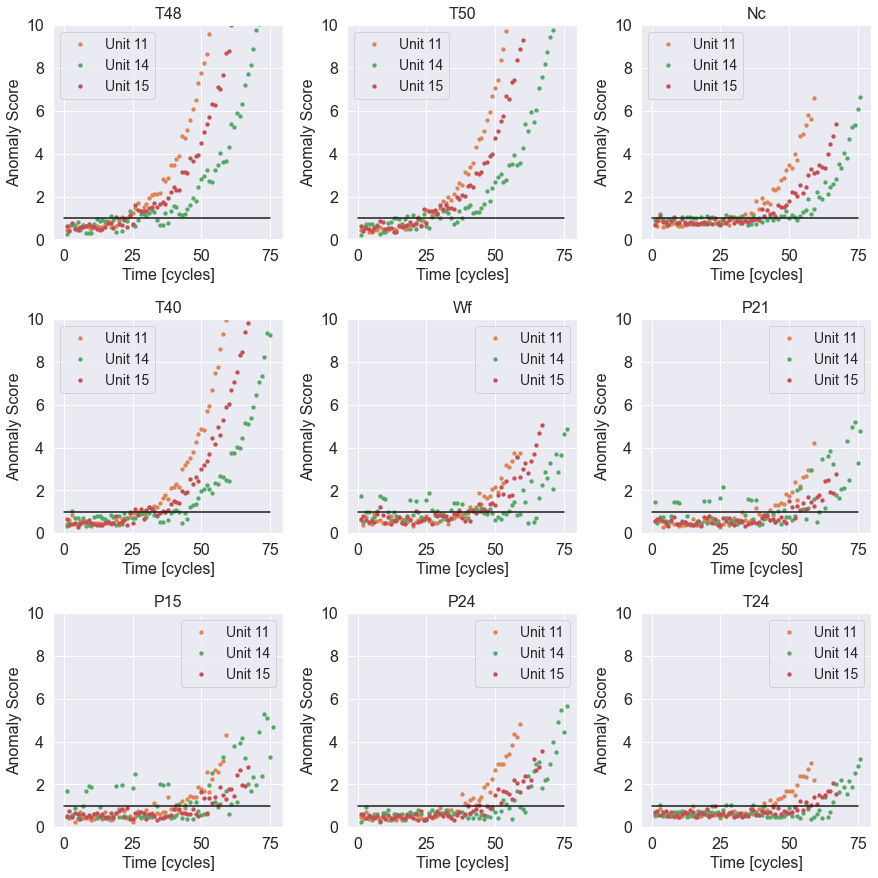

In [37]:
subset = idx_top[0:9]
data, data[0] = {}, {}
data[0]['variables'] = [var_names[x] for x in subset]     # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['ds_name'] = ['test', 'threshold']
data[0]['ylabel'] ='score'
data[0]['xlabel'] ='Time [cycles]'

# Data to plot
data[0]['test'] = {}
data[0]['test']['y'] = d_test[:,subset] 
data[0]['test']['x'] = c_test
data[0]['test']['units'] = u_test

thrs_test = np.ones(np.max(c_test)).reshape(-1,1)
data[0]['threshold'] = {}
data[0]['threshold']['y'] = np.repeat(thrs_test, len(subset), axis=1)
data[0]['threshold']['x'] = np.arange(data[0]['threshold']['y'].shape[0])
data[0]['threshold']['marker'] = 'k-'

# Plot limits
y_min = 0.0           # Min y
y_max = 10.0          # Max y

# Plot
plot_variables_iso(data, figsize=12.5, y_min=y_min, y_max=y_max)

## Step 2.5:  Fault detection with an unbounded anomaly score in $\mathcal{D}_{T_*}$ 

We can observe from the figure above that the effect of degradation is notizable at different point in times (i.e., cycles `c`) for each units. Therefore, we might be interested to have an agregated metric indicating an early presence of an anomaly. To do so, we can then compute a similar metric of dissimilarity

\begin{equation}
  s_{u}^{[c]} =  \frac{max(|\delta_{u}^{[c]}|)}{\nu^{[c]}}
\end{equation}

We make use of the auxiliary function `mae_per_cycle()` with the additional argument `option='max'`

In [38]:
mae_lab_val, c_lab_val, u_lab_val = mae_per_cycle(delta_lab_val, U_lab_val, C_lab_val, option='max')
threshold = np.percentile(mae_lab_val, 99.9, axis=0)

# Test dataset
mae_test, c_test, u_test = mae_per_cycle(delta_test, U_test, C_test, option='max')
s_test= mae_test/threshold


['Score']


<Figure size 432x288 with 0 Axes>

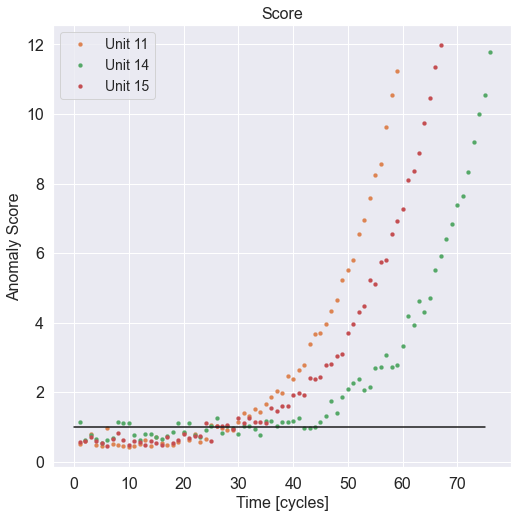

In [39]:
data, data[0] = {}, {}
data[0]['variables'] = ['Score']
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['ds_name'] = ['test', 'threshold']
data[0]['ylabel'] ='score'
data[0]['xlabel'] ='Time [cycles]'

# Data to plot
data[0]['test'] = {}
data[0]['test']['y'] = s_test.reshape(-1,1)
data[0]['test']['x'] = c_test
data[0]['test']['units'] = u_test

data[0]['threshold'] = {}
data[0]['threshold']['y'] = np.ones(np.max(c_test)).reshape(-1,1)
data[0]['threshold']['x'] = np.arange(data[0]['threshold']['y'].shape[0])
data[0]['threshold']['marker'] = 'k-'

# Plot
plot_variables_iso(data, figsize=7.5)

The estimated health conditions is given by setting a threshold based on the training behaviour: 

\begin{equation}
	\hat{h}_{s}^{[c]} = 
	\begin{cases} 
		1 &   s_{u}^{[c]}  < 1  \\
		0 & \text{otherwise} 
	\end{cases}
\end{equation}

In [40]:
h_hat_test = np.where(s_test<1,1,0)
fault_onset = {'11':19, '14':36, '15': 24}

<Figure size 432x288 with 0 Axes>

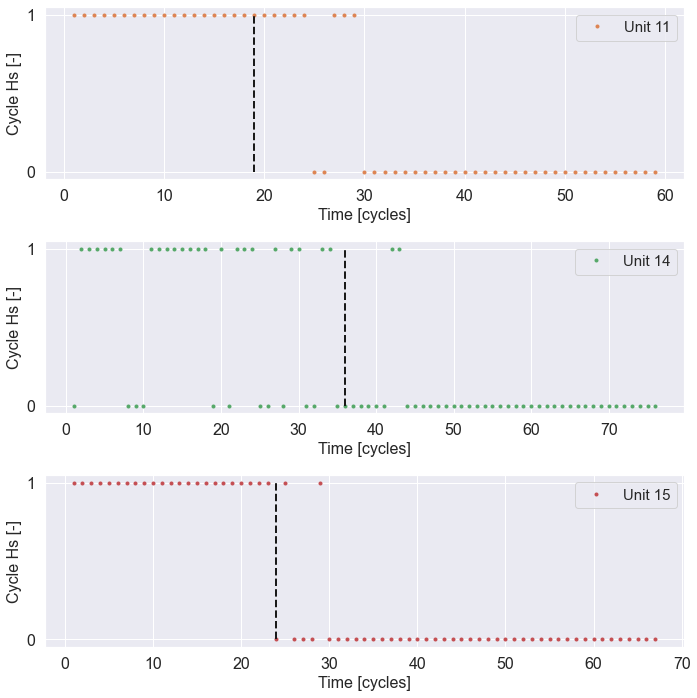

In [41]:
data = {}
color_dic = {'11': 'C1', '12': 'C11', '13': 'C12', '14': 'C2', '15': 'C3'}  

for ii, elm in enumerate(np.unique(u_test)):
    # Set up
    data[ii] = {}
    data[ii]['variables'] = ['Score']
    data[ii]['label'] = data[ii]['variables']
    data[ii]['ds_name'] = ['test']
    data[ii]['ylabel'] ='Cycle Hs [-]'
    data[ii]['xlabel'] ='Time [cycles]'
    
    # Data to plot
    mask_u = np.ravel(u_test==elm)
    data[ii]['test'] = {}
    data[ii]['test']['y'] = h_hat_test[mask_u]
    data[ii]['test']['x'] = c_test[mask_u]
    data[ii]['test']['units'] = u_test[mask_u]
    data[ii]['test']['fault'] = fault_onset[str(elm)]

# Plot
subplot_per_unit(data, color_dic)

We can now compute the aggregated fault detection performaces by computing the recall and precision scores. 

In [42]:
h_true_test = get_y_true(c_test, u_test, fault_onset)
recall, precision = evaluate_detection(h_true_test, h_hat_test)
print('recall:', round(recall,3))
print('precision:', round(precision,3))

recall: 0.823
precision: 0.844


to summarize, the reconstruction model using an AE allows for fault detection but not for fault isolation.

# Part 3: Fault diagnostics with a regression model $\hat{x}_s^{(t)}= \mathcal{D}(w^{(t)})$

The reconstruction model provided quite good results when using it to detect the onset of degradation in different units. The performance was better for units whose healthy operating conditions were well represented in the training data. A clear downside of the reconstruction AE model is its difficulty in locating the faulty sensors. If we try to observe which variables suffered the largest reconstruction residuals, we notice that some of these variables are actually the operating condition sensors, such as the TRA. Reporting a fault in the TRA is non-physical and results from the fact that the reconstruction errors are redistributed among all output variables, including also the operating conditions. This redistribution is sometimes called "spill-over" or "leakage" of residuals and hinders the correct fault localization in most applications of AE networks for anomaly detection. In order to avoid this, we suggest using our prior physical knowledge of the system to come up with a healthy state model, which is based on the regression of a set of output variables using a different set of inputs. Based on physical consideration, it makes sense to use the operative conditions $w$ as inputs and the rest of the sensor values $x_s$ as outputs. The reasoning behind this input-output separation is that we expect the fault mechanisms not to affect the operating conditions, such as the altitude or the Mach number, but we do expect fault mechanisms that will affect the response values of the pressure and temperature in various parts of the engine. 

By training the regression model with healthy data only, we hope to achieve a dynamic model of the healthy system, which is capable of mapping the inputs to the expected outputs during healthy operation. During prediction, the model is fed with input variables, and the predicted outputs are compared with the measured sensor values. Large residuals are then interpreted as anomalies. In this case, as opposed to the reconstruction model, we expect a one-to-one correspondence between the faulty sensor and the large residual. This will allow us to localize the sensor(s) which are most affected by the fault. 

Implementing this solution strategy requires the following steps:

* **Step 3.1:** Create a model $\mathcal{G}$ of the healthy system response i.e. sensor readings $x_s^{(t)} \in \mathcal{D}_{L}$ of the system.
* **Step 3.2:** Compute the expected, i.e., model predictions response of the system $\hat{x}_s^{(t)}$
* **Step 3.3:** Compute residuals between sensor readings $x_s^{(t)}$ and model predictions $\hat{x}_s^{(t)}$.
* **Step 3.4:** Identity residual with significant deviations. Hopefully, they indicate the location of the fault.
* **Step 3.5:** Fault detection with an unbounded anomaly score in $\mathcal{D}_{T_*}$ 

## Step 3.1: Create a model $\mathbf{\mathcal{G}}$ of the healthy system response i.e. $x_s^{(t)} \in \mathcal{D}_{L}$.

Given `X_{train, val, test}` and `Y_{train, val, test}` datasets, the code below allows the generation and optimization of autoencoder networks. The network architecture (or search space) is specified in the `config` dictionary. The optimisation is carried out by grid rearch. Each configuration is run `n_runs` times. Each generated model is stored in `MODEL_PATH` as a `.h5` file.

The provided code contains four functions:
1. `create_supervised_X(X, output_shape, config)`
2. `create_supervised(input_shape, output_shape, config)`
4. `fit_model(MODEL_PATH, X_{train, val, test}, Y_{train, val, test}, config)`
5. `grid_search(MODEL_PATH, X_{train, val, test}, Y_{train, val, test}, config, n_runs)`

In particular we will consider the a simple model $\mathcal{G}$ that approximates the expected system response given current operative condtions $w^{(t)}$, resulting in:

\begin{equation}
  {\hat{x}_s}^{(t)} = \mathcal{G}(w^{(t)})
\end{equation}

We will model $\mathcal{G}$ with a deep MLP.

In [43]:
def create_supervised_X(X, output_shape, config):
    """
    inputs:
        input_shape: tuple with input shape
        output_shape: integer with output shape
        config: dictionary with NN configuration i.e. hyperparameters) but ...
    outputs:
        X: output layer        
    """
    
    # Set-up
    n_dense = config['n_hl']-1  # The number of hidden of layers minus the output layer
    cells = [config['n_cl'] for i in range(n_dense)]
       
    # Hidden layers
    for i in range(n_dense):
        X = tf.keras.layers.Dense(cells[i], 
                                  activation=config['activ'],
                                  kernel_initializer=tf.keras.initializers.glorot_uniform(seed=config['seed']))(X) 
    
    # Dropout layer 
    if config['dropout'] != 0.0:
        X = tf.keras.layers.Dropout(config['dropout'])(X)
    
    # Hidden fully connected linear layer (no activation)
    X = tf.keras.layers.Dense(config['n_fc'],
                              kernel_initializer=tf.keras.initializers.glorot_uniform(seed=config['seed']))(X)
    
    # Output layer
    X = tf.keras.layers.Dense(output_shape)(X)

    return X

def create_supervised(input_shape, output_shape, config):
    """
    inputs:
        input_shape: tuple with input shape
        output_shape: integer with output shape
        config: dictionary with NN configuration i.e. hyperparameters) but ...
    outputs:
        supervised: tf model        
    """
      
    # Define the input placeholder as a tensor with shape input_shape    
    X_input = tf.keras.Input(shape=input_shape)

    # Create model
    X = create_supervised_X(X_input, output_shape, config)
    supervised = tf.keras.Model(inputs=X_input, outputs=X, name='supervised')
       
    # Optimisation 
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

    # Compilation
    supervised.compile(loss=tf.losses.MeanSquaredError(), optimizer=opt)
    
    return supervised

def train_model(OUTFOLDER, 
                X_train, Y_train, 
                X_val, Y_val,
                X_test, Y_test, 
                config, label, generate):
    """
    Creates and trains a NN with supervised learning strategy: 
    define model shapes, create model, fit model, plot training loss and save model
    inputs:
        OUTFOLDER: path to storage or model folder
        X_{train, val, test}: np.array with train and test input features.
        Y_{train, val, test}: np.array with train and test target features.
        config: dictionary with NN configuration (i.e. hyperparameters) but ...
        label: str with model name for storage or loading
        generate_s: boolean with load or run.
    outputs:
        loss_{Tr, Va, Ts}: np.array with loss in train, val and test datasets
        y_hat_{train, test}: np.array with train, val and test input predictions.        
    """       
    
    if generate:

        # Set-up
        seed = 229
        os.environ['PYTHONHASHSEED'] = '0'
        np.random.seed(seed)
        tf.keras.backend.clear_session()
                        
        # Define model shapes
        input_shape = X_train.shape[1:]
        output_shape = Y_train.shape[-1]
        
        # Create supervised model
        supervised = create_supervised(input_shape, output_shape, config)

        # Report model summary
        supervised.summary()
        
        # Callbacks
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=config['patience'], 
                                                      restore_best_weights = True)

        # Fit model
        history = supervised.fit(X_train, Y_train, 
                                 epochs=config['epochs'],
                                 batch_size=config['batch_size'],
                                 callbacks=[early_stop],
                                 validation_data = (X_val, Y_val),
                                 verbose=0)

        # Evaluate model loss i.e. MSE
        loss_train = supervised.evaluate(x=X_train, y=Y_train)
        loss_val = supervised.evaluate(x=X_val, y=Y_val)
        loss_test = supervised.evaluate(x=X_test, y=Y_test)

        # Plot history loss
        plt.plot(np.sqrt(history.history['loss']))
        plt.plot(np.sqrt(history.history['val_loss']))
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        # Save supervised model
        supervised.save(OUTFOLDER + 'model_' + str(label) + '.h5')
        print("Saved supervised model to disk")
        
    else:
        # Supervised
        supervised = tf.keras.models.load_model(OUTFOLDER + 'model_' + str(label) + '.h5')
        print("Loaded supervised model from disk")

        # Report model summary
        supervised.summary()

        # Compilation
        supervised.compile(optimizer='Adam', loss="mean_squared_error") 

        # Evaluate model i.e. RMS       
        loss_train = supervised.evaluate(x=X_train, y=Y_train)
        loss_val = supervised.evaluate(x=X_test, y=Y_test)
        loss_test = supervised.evaluate(x=X_test, y=Y_test)
    
    # Target predictions
    y_hat_train = supervised.predict(x=X_train)
    y_hat_test = supervised.predict(x=X_test)
    
    return loss_train, loss_val, loss_test, y_hat_train, y_hat_test

def grid_search(MODEL_PATH,
                X_train, Y_train, 
                X_val, Y_val,
                X_test, Y_test, 
                params, n_runs, varInput, generate=True):
    """
    Performs a grid search in a NN with supervised learning strategy: 
    define model shapes, create models, fit models, plot training loss and save models
    inputs:
        MODEL_PATH: path to storage or model folder.
        X_{train, val, test}: np.array with train, val and test input features.
        Y_{train, val, test}: np.array with train, val and test target features.
        params: dictionary, NN possible configurations.
        n_runs: int, each configuration is performed n_runs times.
        varInput: str with mapping label.
        generate: boolean with load or run.
    outputs:
        df: storage dataframe.
        label_best: label of best model.
        ...
        ...
        
    """
    # Set-up
    log_Y_hat_train, log_Y_hat_test, log_loss_val, log_label, log_df = [], [], [], [], []
    df = pd.DataFrame()
    log_loss_val, log_label = [], []
    keys, values = zip(*params.items())
    
    for ii, bundle in enumerate(product(*values)):        # Varing architectures        
        config = dict(zip(keys, bundle))                  # Architecture
        
        for jj in range(n_runs):                          # Check reproducibility - n runs            
            df_k = pd.DataFrame(config, index=[0])
            
            # Simulation label
            label =  varInput + '_h_' + str(ii) +  '_run_' + str(jj)
            print('')
            print('Simulation:', label)

            # Train NN model
            time_start = time.time()
            loss_train, loss_val, loss_test, Y_hat_train, Y_hat_test = \
            train_model(MODEL_PATH, 
                        X_train, Y_train,
                        X_val, Y_val,
                        X_test, Y_test, 
                        config, label, generate=generate)

            # Store results
            log_Y_hat_train.append(Y_hat_train)
            log_Y_hat_test.append(Y_hat_test)
            log_loss_val.append(loss_val)
            log_label.append(label)
            
            # Global log of results
            df_k['run']= jj
            df_k['input'] = varInput
            df_k['RMSE-Ts'] = np.round(np.sqrt(np.mean((Y_hat_test - Y_test)**2)), 3)
            df_k['RMSE-Tr'] = np.round(np.sqrt(np.mean((Y_hat_train - Y_train)**2)), 3)
            df_k['Time[min]'] = np.round((time.time()-time_start)/60, 2)            
            log_df.append(df_k)
            df = pd.concat(log_df, ignore_index=True)
            print('')
            print(df.to_string())

            # Write solutions to 
            df.to_csv(MODEL_PATH + 'Training_' +  varInput + '.csv')

    return log_Y_hat_train, log_Y_hat_test, df, log_loss_val, log_label

**Define newtwork architecture**

In [44]:
# Supervised network
params = {"activ": ['relu'],    # Activation - h1 = ['tanh', 'relu']
          "n_hl": [4],          # Number of hidden layers - h2 = [1, 2, 3]
          "n_cl":  [100],       # Number of channels per cnn-type hidden layer (the same for all) - h3 = [50, 100, 150]   
          "n_fc": [50],         # Number of neurons in fully connected layer - h4 = [50, 100, 200]
          "dropout": [0.0],     # Dropout - h5 = [0.1, 0.2, 0.5]
          "batch_size": [64],   # Batch size autoencoder - h6 = [64, 512, 1024]    
          "epochs": [50],       # Epochs - h7 (on demand) 400
          "seed": [229],        # Seed
          "patience": [15]
          }

# Number of runs per NN architecture
n_runs = 5

**Define the inputs and targets variables for training, validation and test i.e., `X_train`, `Y_train`,  `X_val`, `Y_val` `X_test` and `Y_test`.**

In [45]:
# Inputs
X_train = W_lab_train
X_val = W_lab_val
X_test = W_test

# Targets
Y_train = Xs_lab_train
Y_val = Xs_lab_val
Y_test = Xs_test

# Model tag 
input_s = 'W_Xs'      
target_s = 'Xs' 
varInput = input_s + '-' + target_s
var_names = Xs_var

**Fit model according to the defined inputs and targets variables** 


Simulation: W_Xs-Xs_h_0_run_0
Model: "supervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 100)               500       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dense_4 (Dense)             (None, 16)                816       
                                                                 
Total params: 26,566
Trai

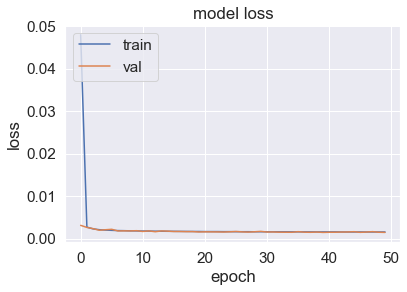

Saved supervised model to disk

  activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run    input  RMSE-Ts  RMSE-Tr  Time[min]
0  relu     4   100    50      0.0          64      50   229        15    0  W_Xs-Xs    0.006    0.002        1.2

Simulation: W_Xs-Xs_h_0_run_1
Model: "supervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 100)               500       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             

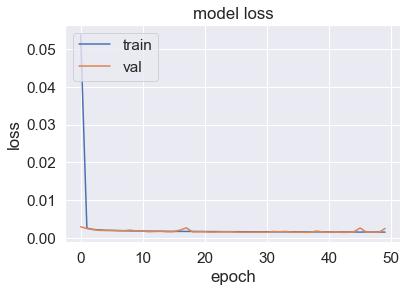

Saved supervised model to disk

  activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run    input  RMSE-Ts  RMSE-Tr  Time[min]
0  relu     4   100    50      0.0          64      50   229        15    0  W_Xs-Xs    0.006    0.002       1.20
1  relu     4   100    50      0.0          64      50   229        15    1  W_Xs-Xs    0.006    0.003       1.08

Simulation: W_Xs-Xs_h_0_run_2
Model: "supervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 100)               500       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)       

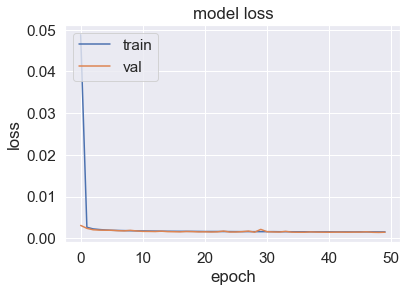

Saved supervised model to disk

  activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run    input  RMSE-Ts  RMSE-Tr  Time[min]
0  relu     4   100    50      0.0          64      50   229        15    0  W_Xs-Xs    0.006    0.002       1.20
1  relu     4   100    50      0.0          64      50   229        15    1  W_Xs-Xs    0.006    0.003       1.08
2  relu     4   100    50      0.0          64      50   229        15    2  W_Xs-Xs    0.006    0.002       1.04

Simulation: W_Xs-Xs_h_0_run_3
Model: "supervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 100)               500       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     

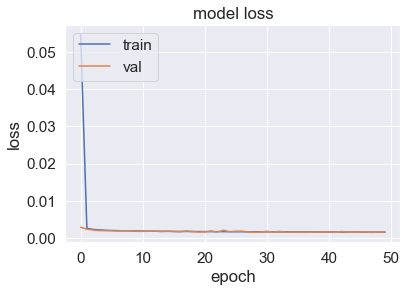

Saved supervised model to disk

  activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run    input  RMSE-Ts  RMSE-Tr  Time[min]
0  relu     4   100    50      0.0          64      50   229        15    0  W_Xs-Xs    0.006    0.002       1.20
1  relu     4   100    50      0.0          64      50   229        15    1  W_Xs-Xs    0.006    0.003       1.08
2  relu     4   100    50      0.0          64      50   229        15    2  W_Xs-Xs    0.006    0.002       1.04
3  relu     4   100    50      0.0          64      50   229        15    3  W_Xs-Xs    0.006    0.002       1.02

Simulation: W_Xs-Xs_h_0_run_4
Model: "supervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 100)               500       
                 

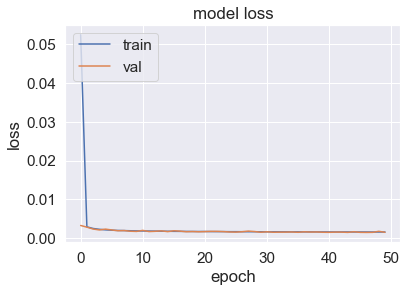

Saved supervised model to disk

  activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run    input  RMSE-Ts  RMSE-Tr  Time[min]
0  relu     4   100    50      0.0          64      50   229        15    0  W_Xs-Xs    0.006    0.002       1.20
1  relu     4   100    50      0.0          64      50   229        15    1  W_Xs-Xs    0.006    0.003       1.08
2  relu     4   100    50      0.0          64      50   229        15    2  W_Xs-Xs    0.006    0.002       1.04
3  relu     4   100    50      0.0          64      50   229        15    3  W_Xs-Xs    0.006    0.002       1.02
4  relu     4   100    50      0.0          64      50   229        15    4  W_Xs-Xs    0.006    0.002       1.11


In [46]:
# Working folder: storage
ROOT_PATH_3 = 'models/00-SL-MLP'
MODEL_PATH_3 = ROOT_PATH_3  + '/DS02_' + strftime("%Y-%m-%d", gmtime()) + '/'
if not os.path.exists(MODEL_PATH_3):
    os.makedirs(MODEL_PATH_3)

# Fit model
log_Y_hat_train, log_Y_hat_test, df, log_loss_val, log_label_3 = grid_search(MODEL_PATH_3, 
                                                                 X_train, Y_train, 
                                                                 X_val, Y_val,
                                                                 X_test, Y_test,
                                                                 params, n_runs, varInput, generate=True)

## Step 3.2: Compute model predictions on labeled ($\mathcal{D}_{L}$) and test $\mathcal{D}_{T_*}$ datasets

Once $\mathcal{G}$ is learned with $w^{(t)} \in \mathcal{D}_{L}$ then it can be used to compute predictions i.e., sensor readings ($x_{s*}^{(t)}$) given new operative conditions i.e.,  $w_*^{(t)} \in \{\mathcal{D}_{U}, \mathcal{D}_{T_*}\}$. 

\begin{equation}
  {\hat{y}}^{(t)} = \mathcal{G}_{phy}(w^{(t)}, x_s^{(t)})  \quad with  \quad {\hat{y}}^{(t)} = \hat{x}_s^{(t)}
\end{equation}

So, now we will compute predictions of the detection model on labeled, i.e., training and valiadtion, and test datasets i.e., `Y_hat_train`, `Y_hat_train` and `Y_hat_test`.

In [47]:
# Select model with best loss on validation set!!
log_loss_val = np.array(log_loss_val)
mask = np.ravel(log_loss_val==min(log_loss_val))
label_3 = list(itertools.compress(log_label_3, mask))[0]

model = tf.keras.models.load_model(MODEL_PATH_3 + 'model_' + str(label_3) + '.h5')
Y_hat_train = model.predict(x=X_train)
Y_hat_val = model.predict(x=X_val)
Y_hat_test = model.predict(x=X_test)

**Labeled dataset**

We plot the true and predicted values for a subset of the labeled dataset (for instance, the last 1000 samples) to check how good the $\mathcal{G}$ model is on healthy data. We can see below that there is a good alligment between `true` and `pred` and (as it will be more clear in the next section) the prediction error is small.


['T24', 'T30', 'T40', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


<Figure size 432x288 with 0 Axes>

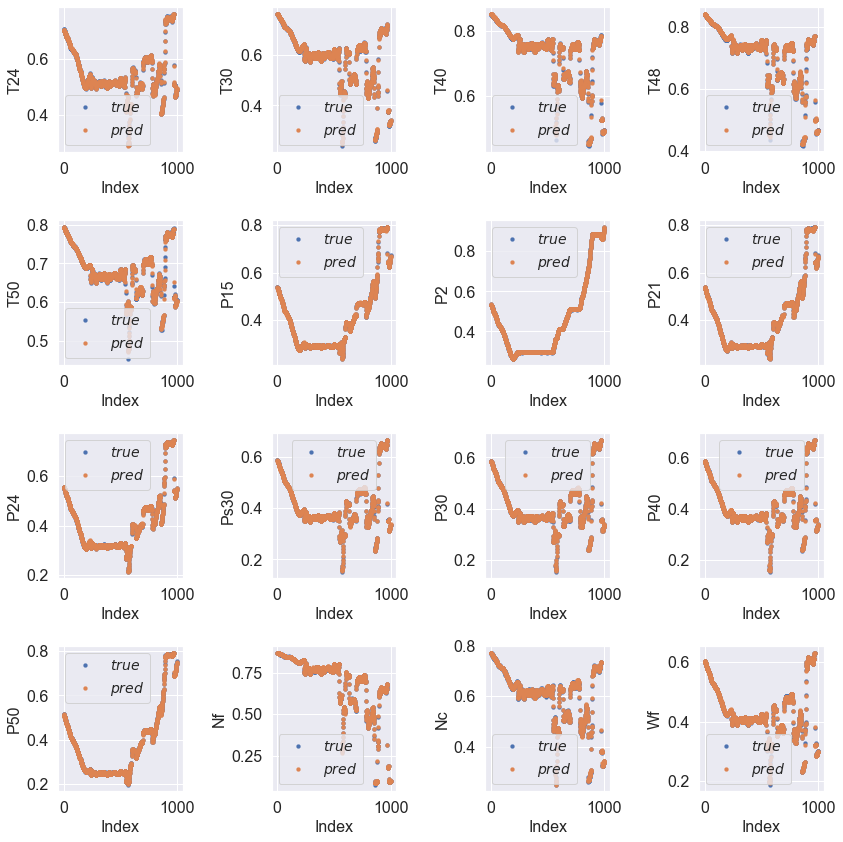

In [48]:
dim1=1000

data, data[0] = {}, {}
data[0]['variables'] = var_names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$true$', '$pred$']
data[0]['ds_name'] = ['true', 'pred']
data[0]['color'] = ['C0', 'C1']

# Data to plot
# True
data[0]['true'] = {}
data[0]['true']['y'] = Y_train[-dim1:,:]
data[0]['true']['x'] = np.arange(data[0]['true']['y'].shape[0])

# Pred
data[0]['pred'] = {}
data[0]['pred']['y'] = Y_hat_train[-dim1:,:]
data[0]['pred']['x'] = np.arange(data[0]['pred']['y'].shape[0])

# Plot
plot_variables_iso(data, figsize=12)

**Test dataset**

We also plot the true and predicted values for subset of the test dataset (for instance the last 1000 samples). We can observe that the reconstruction error of variables `T40`, `T48`, `T50` and `Wf` is particularly high indicating the presence of a degradation on the test data.


['T24', 'T30', 'T40', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


<Figure size 432x288 with 0 Axes>

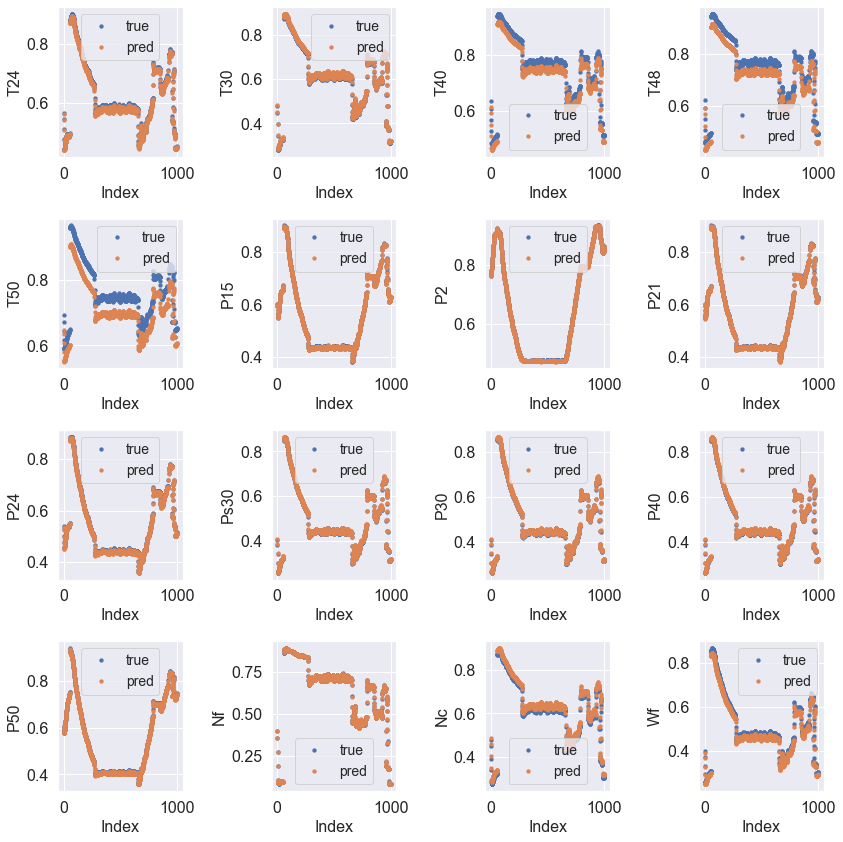

In [49]:
dim1=1000

data, data[0] = {}, {}
data[0]['variables'] = var_names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['true', 'pred']
data[0]['ds_name'] = ['true', 'pred']
data[0]['color'] = ['C0', 'C1']

# Data to plot
data[0]['true'] = {}
data[0]['true']['y'] = Y_test[-dim1:,:]
data[0]['true']['x'] = np.arange(data[0]['true']['y'].shape[0])

data[0]['pred'] = {}
data[0]['pred']['y'] = Y_hat_test[-dim1:,:]
data[0]['pred']['x'] = np.arange(data[0]['pred']['y'].shape[0])

# Plot
plot_variables_iso(data, figsize=12)

## Step 3.3: Compute residuals between sensor readings $x_s^{(t)}$ and model predictions $\hat{x}_s^{(t)}$ on labeled ($\mathcal{D}_{L}$)  and test $\mathcal{D}_{T_*}$ datasets


\begin{equation} 
  \delta^{(t)}= {x_s}^{(t)} - {\hat{x}_s}^{(t)} 
\end{equation}

In [50]:
delta_lab_train = Y_train-Y_hat_train
delta_lab_val = Y_val-Y_hat_val
delta_test = Y_test-Y_hat_test

print('Matrix 2-norm test dataset:', round(np.linalg.norm(delta_test, ord=2),3))
print('Matrix Frobenius norm test dataset:', round(np.linalg.norm(delta_test, ord='fro'),3))
print('')
print('Matrix 2-norm train dataset:', round(np.linalg.norm(delta_lab_train, ord=2),3))
print('Matrix Frobenius norm train dataset:', round(np.linalg.norm(delta_lab_train, ord='fro'),3))

Matrix 2-norm test dataset: 8.419
Matrix Frobenius norm test dataset: 8.643

Matrix 2-norm train dataset: 1.058
Matrix Frobenius norm train dataset: 1.55


**Labeled dataset**

We plot the predicted error values for the labeled dataset.


['T24', 'T30', 'T40', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


<Figure size 432x288 with 0 Axes>

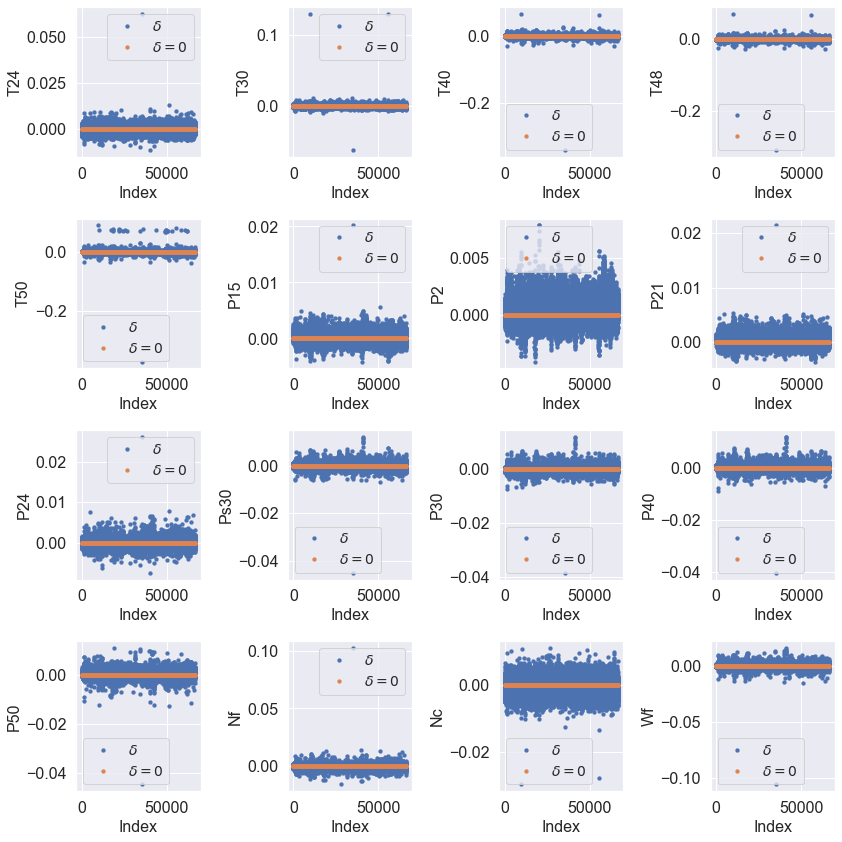

In [51]:
data, data[0] = {}, {}
data[0]['variables'] = var_names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$\delta$', '$\delta=0$']
data[0]['ds_name'] = ['delta', 'zero']
data[0]['color'] = ['C0', 'C1']

# Data to plot
# delta = True - pred
data[0]['delta'] = {}
data[0]['delta']['y'] = delta_lab_train
data[0]['delta']['x'] = np.arange(data[0]['delta']['y'].shape[0])

# Zero line
data[0]['zero'] = {}
data[0]['zero']['y'] = np.zeros(shape=data[0]['delta']['y'].shape)
data[0]['zero']['x'] = np.arange(data[0]['zero']['y'].shape[0])

# Plot
plot_variables_iso(data, figsize=12)

**Test dataset**

We also plot the true and predicted values for subset of the test dataset (for instance the last 1000 samples). We can observe that the reconstruction error of variables `T40`, `T48`, `T50` and `Wf` is particularly high indicating the presence of a degradation on the test data.


['T24', 'T30', 'T40', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


<Figure size 432x288 with 0 Axes>

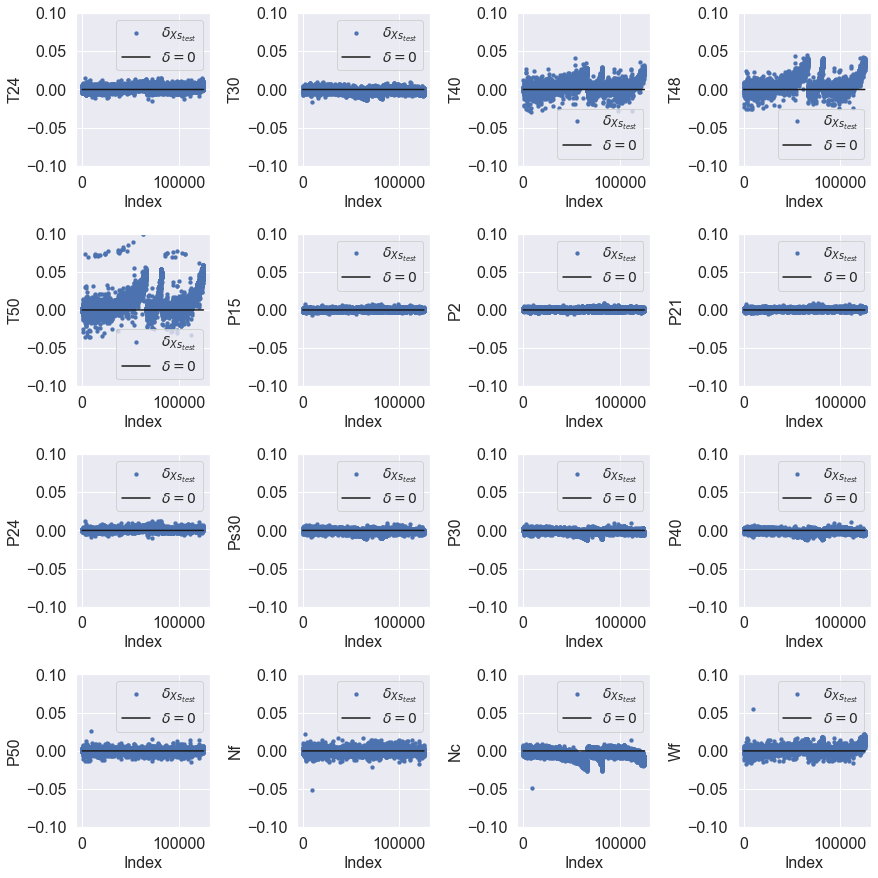

In [52]:
data, data[0] = {}, {}
data[0]['variables'] = var_names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$\delta_{Xs_{test}}$', '$\delta=0$']
data[0]['ds_name'] = ['delta', 'zero']
data[0]['color'] = ['C0', 'C1']

# Data to plot
data[0]['delta'] = {}
data[0]['delta']['y'] = delta_test[:,:]
data[0]['delta']['x'] = np.arange(data[0]['delta']['y'].shape[0])
#data[0]['delta']['units'] = U_test

data[0]['zero'] = {}
data[0]['zero']['y'] = np.zeros(shape=data[0]['delta']['y'].shape)
data[0]['zero']['x'] = np.arange(data[0]['zero']['y'].shape[0])
data[0]['zero']['marker'] = 'k-'

# Plot limits
y_min = -0.1              # Min y
y_max = 0.1             # Max y

# Plot
plot_variables_iso(data, figsize=12.5, y_min=y_min, y_max=y_max)

## Step 3.4:  Identify features with larger deviations on the test set $\mathcal{D}_{T_*}$ 

The system model $\mathcal{G}$ allows the computation of the expected $[\hat{w}^{(t)}, \hat{x}_{s*}^{(t)}]$signal values under the training input conditions (i.e., $w$). The output of the $\mathcal{G}$, i.e., $\hat{x}_{s*}^{(t)}$ will deviate from the input value $x_{s*}$ when the inner relationship of a new data point $x_{s*}^{(j)} \in \{\mathcal{D}_{U},\mathcal{D_{T}}\}$ does not correspond to the one observed in the training set $S_{T}$. Therefore, we compute the absolute deviation that each component of the reconstructed signals has (i.e., $|\delta^{(t)}_k|$) relative to the error observed in the validation dataset $S_V$ (i.e., healthy operation conditions).

\begin{equation} 
  d_I(x_k^{(j)};\nu_k) =  \frac{|\delta_k^{(j)}|}{\nu_k}
\end{equation}

where $\nu$ corresponds to a normalizing threshold given by the 99.9\% percentile of the absolute error of the prediction of $F$ in the validation set $S_{V}$


\begin{equation}
  \nu_k = P_{99.9}\big(\{|\delta_k^{(i)}| \; | \; x_k^{(i)}\in S_V\}\big) % \; \forall
\end{equation}

$d_I(x_k^{(j)};\nu)$ is an unbounded measure of similarity between the signal value predicted by $\mathcal{G}$ and the expected or true signal value.

### Fault isolation?
The regression residuals of each output variable can now be computed. Can we assign a physical meaning to these residuals? Is there a relation between the magnitude of the residuals and the appearance of a fault in the respective sensor? Similarly to the reconstruction case we compute the mean absolute residuals over the entire test data for each output variable. In this case, the outputs are all response variables so we avoid the non-physical effect of smearing the errors onto the operative conditions $w$, which are here defined as inputs. Thus, it is easier to assign a physical meaning to a large residual in a specific variable. Since the prediction errors are independent of each other, each one of them has a physical meaning corresponding to abnormal sensor values of the respective variable. This can be verified directly using a physical model.

In [53]:
DI_test, delta_sorted, idx_top = evaluate_isolation(Y_test, Y_hat_test, delta_lab_val)
report_isolation(delta_sorted, idx_top, var_names)

Nc  :  0.629
T48  :  0.549
T50  :  0.51
T30  :  0.394
T40  :  0.377
P30  :  0.339
P40  :  0.324
Wf  :  0.299
T24  :  0.295
Ps30  :  0.281



['Nc', 'T48', 'T50', 'T30', 'T40', 'P30', 'P40', 'Wf', 'T24']


<Figure size 432x288 with 0 Axes>

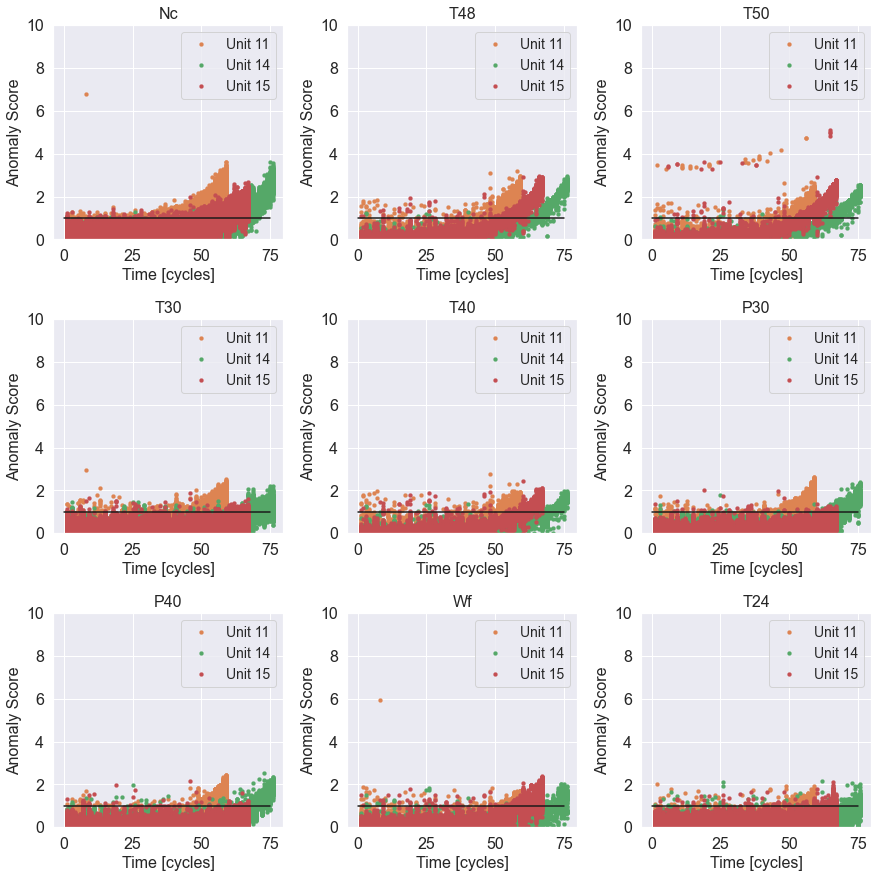

In [54]:
subset = idx_top[0:9]
data, data[0] = {}, {}
data[0]['variables'] = [var_names[x] for x in subset]     # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['ds_name'] = ['test', 'threshold']
data[0]['ylabel'] ='score'
data[0]['xlabel'] ='Time [cycles]'

# Data to plot
data[0]['test'] = {}
data[0]['test']['y'] = DI_test[:,subset] 
data[0]['test']['x'] = C_test
data[0]['test']['units'] = U_test

thrs_test = np.ones(np.max(C_test)).reshape(-1,1)
data[0]['threshold'] = {}
data[0]['threshold']['y'] = np.repeat(thrs_test, len(subset), axis=1)
data[0]['threshold']['x'] = np.arange(data[0]['threshold']['y'].shape[0])
data[0]['threshold']['marker'] = 'k-'

# Plot limits
y_min = 0.0           # Min y
y_max = 10.0          # Max y

# Plot
plot_variables_iso(data, figsize=12.5, y_min=y_min, y_max=y_max)

It is worth noting that ${d_I}(x_k^{(j)};\nu_k)$ are obtained at each point in time at which a new sample is available. Therefore, unit-specific pointwise estimations can show high variability within a flight cycle. In order to mitigate this effect, we also define the average $d_I$ at cycle $c$ in unit $u$ (i.e., ${d_I}_{u}^{[c]}$), which is defined as follows: 

\begin{align}
	 {d_I}_{u}^{[c]} &= \frac{1}{m_u^{[c]}} \sum_{j=1}^{m_u^{[c]}}  {d_I}_{u}(x_k^{(j)};\nu_k)
\end{align}

where $m_u^{[c]}$ is the length of the flight cycle $c$ for the \textit{u-th} unit, which is formally defined using the indicator function, i.e., $\mathbf{1}\{.\}$, as:

\begin{align}
m_u^{[c]}=\sum_{j=1}^{m_*} \mathbf{1}\{U^{(j)} = u \; \wedge \; C^{(j)}=c\}
\end{align}

We can compute the with the function  `mean_per_cycle()` 

In [55]:
di_test, c_test, u_test = mean_per_cycle(DI_test, U_test, C_test)

It is worth noting that at also unit-specific pointwise residuals (i.e., $\delta_{u}^{(j)}$) can show high variability within a flight cycle. Therefore, similarly as before, we can also define the average residual at cycle $c$ in unit $u$ ($\hat{y}_u^{[c]}$), which is defined as follows: 

\begin{align}
	\delta_{u}^{[c]} &= \frac{1}{m_u^{[c]}} \sum_{j=1}^{m_u^{[c]}} \delta_u^{(j)}
\end{align}

We can then compute the mean absolute error per cycle using the auxiliary function `mae_per_cycle()`; and compute an alternative metric of dissimilarity defined as follows:

\begin{equation}
  d_{u}^{[c]} =  \frac{|\delta_{u}^{[c]}|}{\nu^{[c]}}
\end{equation}

where $\nu^{[c]}$ corresponds to a normalizing threshold given by the 99.9\% percentile of the absolute error $d^{[c]}$ in the validation set $S_{V}$.


['Nc', 'T48', 'T50', 'T30', 'T40', 'P30', 'P40', 'Wf', 'T24']


<Figure size 432x288 with 0 Axes>

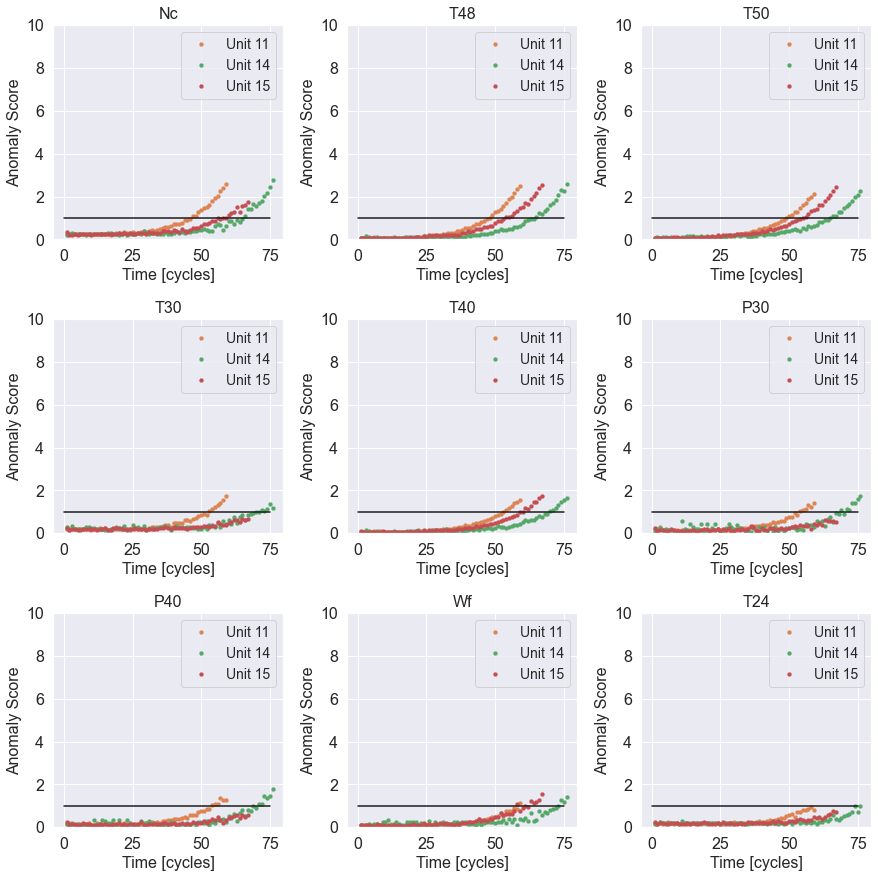

In [56]:
subset = idx_top[0:9]
data, data[0] = {}, {}
data[0]['variables'] = [var_names[x] for x in subset]     # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['ds_name'] = ['test', 'threshold']
data[0]['ylabel'] ='score'
data[0]['xlabel'] ='Time [cycles]'

# Data to plot
data[0]['test'] = {}
data[0]['test']['y'] = di_test[:,subset] 
data[0]['test']['x'] = c_test
data[0]['test']['units'] = u_test

thrs_test = np.ones(np.max(c_test)).reshape(-1,1)
data[0]['threshold'] = {}
data[0]['threshold']['y'] = np.repeat(thrs_test, len(subset), axis=1)
data[0]['threshold']['x'] = np.arange(data[0]['threshold']['y'].shape[0])
data[0]['threshold']['marker'] = 'k-'

# Plot limits
y_min = 0.0           # Min y
y_max = 10.0          # Max y

# Plot
plot_variables_iso(data, figsize=12.5, y_min=y_min, y_max=y_max)

In [57]:
mae_lab_val, c_lab_val, u_lab_val = mae_per_cycle(delta_lab_val, U_lab_val, C_lab_val)
threshold = np.percentile(mae_lab_val, 99.9, axis=0)

# Test dataset
mae_test, c_test, u_test = mae_per_cycle(delta_test, U_test, C_test)
d_test= mae_test/threshold


['Nc', 'T48', 'T50', 'T30', 'T40', 'P30', 'P40', 'Wf', 'T24']


<Figure size 432x288 with 0 Axes>

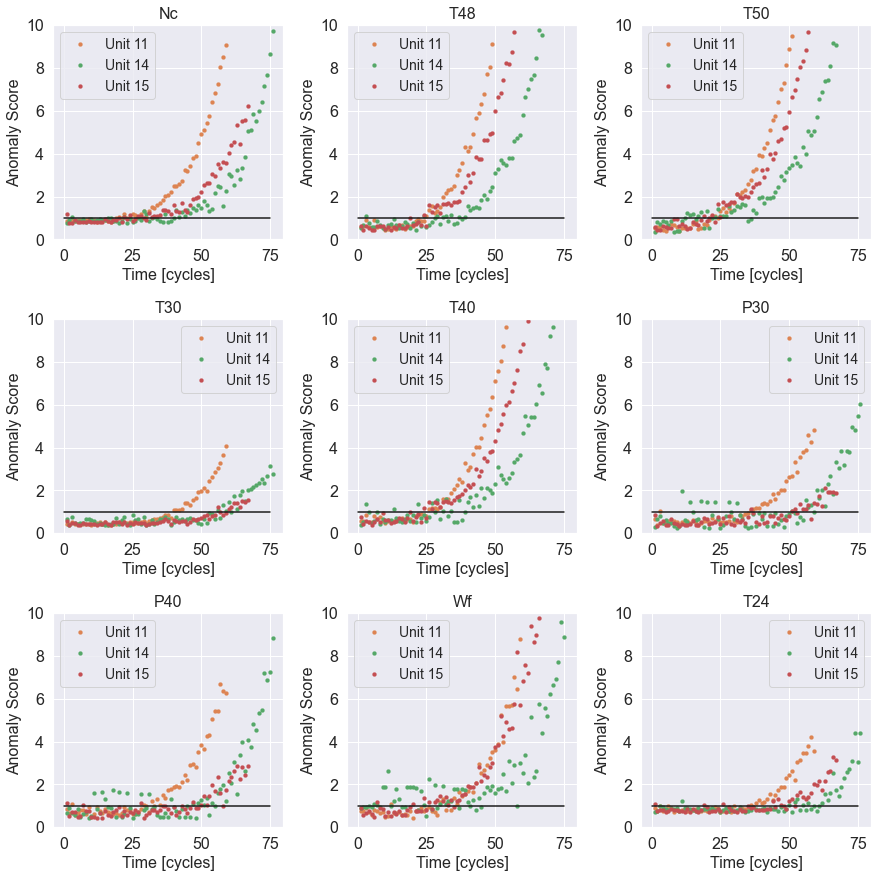

In [58]:
subset = idx_top[0:9]
data, data[0] = {}, {}
data[0]['variables'] = [var_names[x] for x in subset]     # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['ds_name'] = ['test', 'threshold']
data[0]['ylabel'] ='score'
data[0]['xlabel'] ='Time [cycles]'

# Data to plot
data[0]['test'] = {}
data[0]['test']['y'] = d_test[:,subset] 
data[0]['test']['x'] = c_test
data[0]['test']['units'] = u_test

thrs_test = np.ones(np.max(c_test)).reshape(-1,1)
data[0]['threshold'] = {}
data[0]['threshold']['y'] = np.repeat(thrs_test, len(subset), axis=1)
data[0]['threshold']['x'] = np.arange(data[0]['threshold']['y'].shape[0])
data[0]['threshold']['marker'] = 'k-'

# Plot limits
y_min = 0.0           # Min y
y_max = 10.0          # Max y

# Plot
plot_variables_iso(data, figsize=12.5, y_min=y_min, y_max=y_max)

## Step 3.5:  Fault detection with an unbounded anomaly score in $\mathcal{D}_{T_*}$ 

We can observe from the figure above that the effect of degradation is notizable at different point in times (i.e., cycles `c`) for each units. Therefore, we might be interested to have an agregated metric indicating that an ealy presence of an anomaly. To do so, we can then compute a similar metric of dissimilarity

\begin{equation}
  s_{u}^{[c]} =  \frac{max(|\delta_{u}^{[c]}|)}{\nu^{[c]}}
\end{equation}

We make use of the auxiliary function `mae_per_cycle()` with the additional argument `option='max'`

In [59]:
mae_lab_val, c_lab_val, u_lab_val = mae_per_cycle(delta_lab_val, U_lab_val, C_lab_val, option='max')
threshold = np.percentile(mae_lab_val, 99.9, axis=0)

# Test dataset
mae_test, c_test, u_test = mae_per_cycle(delta_test, U_test, C_test, option='max')
s_test= mae_test/threshold


['Score']


<Figure size 432x288 with 0 Axes>

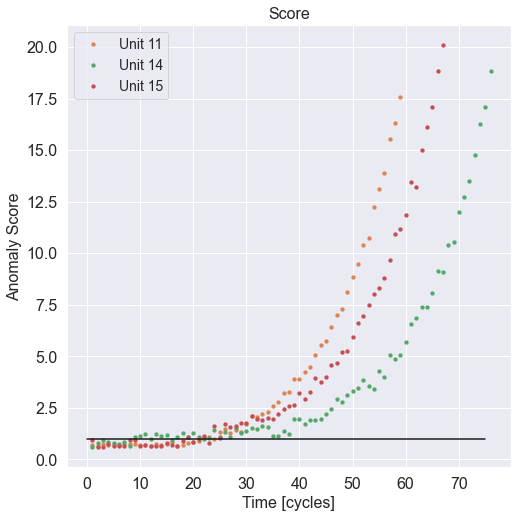

In [60]:
data, data[0] = {}, {}
data[0]['variables'] = ['Score']
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['ds_name'] = ['test', 'threshold']
data[0]['ylabel'] ='score'
data[0]['xlabel'] ='Time [cycles]'

# Data to plot
data[0]['test'] = {}
data[0]['test']['y'] = s_test.reshape(-1,1)
data[0]['test']['x'] = c_test
data[0]['test']['units'] = u_test

data[0]['threshold'] = {}
data[0]['threshold']['y'] = np.ones(np.max(c_test)).reshape(-1,1)
data[0]['threshold']['x'] = np.arange(data[0]['threshold']['y'].shape[0])
data[0]['threshold']['marker'] = 'k-'

# Plot
plot_variables_iso(data, figsize=7.5)

The estimated health conditions is given by: 

\begin{equation}
    \hat{h}_{s}^{[c]} = 
    \begin{cases} 
        1 &   s_{u}^{[c]}  < 1  \\
        0 & \text{otherwise} 
    \end{cases}
\end{equation}

In [61]:
h_hat_test = np.where(s_test<=1,1,0)
fault_onset = {'11':19, '14':36, '15': 24}

<Figure size 432x288 with 0 Axes>

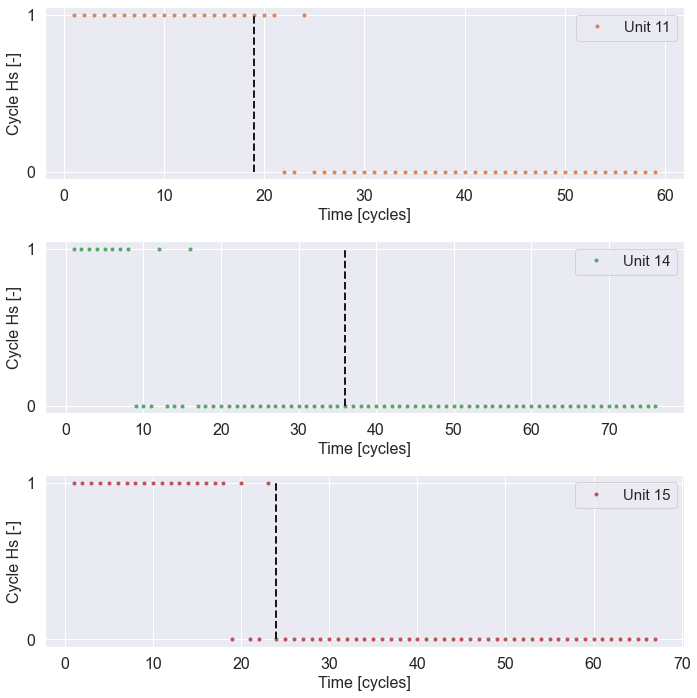

In [62]:
data = {}
color_dic = {'11': 'C1', '12': 'C11', '13': 'C12', '14': 'C2', '15': 'C3'}  

for ii, elm in enumerate(np.unique(u_test)):
    # Set up
    data[ii] = {}
    data[ii]['variables'] = ['Score']
    data[ii]['label'] = data[ii]['variables']
    data[ii]['ds_name'] = ['test']
    data[ii]['ylabel'] ='Cycle Hs [-]'
    data[ii]['xlabel'] ='Time [cycles]'
    
    # Data to plot
    mask_u = np.ravel(u_test==elm)
    data[ii]['test'] = {}
    data[ii]['test']['y'] = h_hat_test[mask_u]
    data[ii]['test']['x'] = c_test[mask_u]
    data[ii]['test']['units'] = u_test[mask_u]
    data[ii]['test']['fault'] = fault_onset[str(elm)]

# Plot
subplot_per_unit(data, color_dic)

We can now compute the aggregated fault detection performaces by computing the overall recall, precision on the test set

In [63]:
h_true_test = get_y_true(c_test, u_test, fault_onset)
recall, precision = evaluate_detection(h_true_test, h_hat_test)

print('recall:', round(recall,3))
print('precision:', round(precision,3))

recall: 0.62
precision: 0.942


# Part 4: Model comparison and summary 

To obtain representative results, we now extend the previous analysis to the five simulations performed for each method, i.e., Part 2 and Part 3, and compare their fault detection and isolation performance.

In [64]:
fault_onset = {'11':19, '14':36, '15': 24}

def compute_top_mean_rel_abs_delta(rel_abs_delta, top_n=10):
          
    # Isolation
    mean_rel_abs_delta = np.mean(rel_abs_delta, axis=0)
    sorted_mean_rel_abs_delta = sorted(mean_rel_abs_delta, reverse = True)[0:top_n]
    idx_top_n = list(np.argsort(mean_rel_abs_delta)[::-1][:top_n])   

    return sorted_mean_rel_abs_delta, idx_top_n

def predict_multirun(X_val, Y_val, U_lab_val, C_lab_val,
                     X_test, Y_test, U_test, C_test,
                     var_names, MODEL_PATH, log_label, fault_onset,
                     option='AE', top_n=10):
    
    #Set-up
    log_precision, log_recall, log_isolation = [], [], []

    for i, label in enumerate(log_label): 
        if option=='AE':
            model = tf.keras.models.load_model(MODEL_PATH + 'model_AE_' + str(label) + '.h5')
        elif option=='SL':
            model = tf.keras.models.load_model(MODEL_PATH + 'model_' + str(label) + '.h5')
        
        # Model predictions
        Y_hat_val = model.predict(x=X_val)
        Y_hat_test = model.predict(x=X_test)
        
        # Pointwise residuals
        delta_lab_val = Y_val-Y_hat_val
        delta_test = Y_test-Y_hat_test
       
        # Pointwise (j) relative absolute error (DI) - Test dataset
        DI_test, delta_sorted, idx_top = evaluate_isolation(Y_test, Y_hat_test, delta_lab_val)
        
        # Cycle mean relative absolute error (di) - Test dataset
        di_test, c_test, u_test = mean_per_cycle(DI_test, U_test, C_test)

        # Cycle max. mean absolute error (cmax_mae) - Validaion dataset & threshold calculation
        cmax_mae_lab_val, c_lab_val, u_lab_val = mae_per_cycle(delta_lab_val, U_lab_val, C_lab_val, option='max')
        threshold = np.percentile(cmax_mae_lab_val, 99.9, axis=0)
        
        # Cycle max. mean absolute error (cmax_mae) - Test dataset
        cmax_mae_test, c_test, u_test = mae_per_cycle(delta_test, U_test, C_test, option='max')
        
        # Detection score (s)
        s_test = cmax_mae_test/threshold

        # Health condition (h)  - Test dataset
        h_hat_test = np.where(s_test<=1,1,0)
        h_true_test = get_y_true(c_test, u_test, fault_onset)        
        
        # Detection Performance (recall, precision) - Test dataset
        recall, precision = evaluate_detection(h_true_test, h_hat_test)
        log_recall.append(recall)
        log_precision.append(precision)
        
        #Isolation performance - Test dataset
        top_n_mean_di_test, idx_top_n = compute_top_mean_rel_abs_delta(di_test, top_n=top_n)
        log_isolation.append([var_names[x] for x in idx_top_n])        
        
    return log_precision, log_recall, log_isolation    

To evaluate the detection performance we compute the mean and standard deviation of the prediction and recall obtained with each method. To evaluate the isolation performance we report the `top_n=9` featues with lager cycle mean relative absolute error $\sum_{u}{d_I}_{u}^{[c]}$ on the test dataset.

In [65]:
# Part 2 model     
log_precision, log_recall, log_isolation_2 = predict_multirun(X_val_2, X_val_2, U_lab_val, C_lab_val,
                                           X_test_2, X_test_2, U_test, C_test,
                                           var_names_2, MODEL_PATH_2, log_label_2, fault_onset,
                                           top_n=9, option='AE')

print('')
print('Precisison:', [round(x,3) for x in log_precision])
print('Mean precisison:', round(np.mean(log_precision),3))
print('Std. precisison:', round(np.std(log_precision),2))
print('')
print('Recall:', [round(x,3) for x in log_recall])
print('Mean recall:', round(np.mean(log_recall),3))
print('Std. recall:', round(np.std(log_recall),2))


# Part 3 model     
log_precision, log_recall, log_isolation_3 = predict_multirun(X_val, Y_val, U_lab_val, C_lab_val,
                                           X_test, Y_test, U_test, C_test,
                                           var_names, MODEL_PATH_3, log_label_3, fault_onset,
                                           top_n=9, option='SL')

print('')
print('Precisison:', [round(x,3) for x in log_precision])
print('Mean precisison:', round(np.mean(log_precision),3))
print('Std. precisison:', round(np.std(log_precision),2))
print('')
print('Recall:', [round(x,3) for x in log_recall])
print('Mean recall:', round(np.mean(log_recall),3))
print('Std. recall:', round(np.std(log_recall),2))


Precisison: [0.852, 0.59, 0.844, 0.647, 0.816]
Mean precisison: 0.75
Std. precisison: 0.11

Recall: [0.658, 1.0, 0.823, 0.949, 0.899]
Mean recall: 0.866
Std. recall: 0.12

Precisison: [0.942, 0.693, 0.882, 0.912, 0.826]
Mean precisison: 0.851
Std. precisison: 0.09

Recall: [0.62, 1.0, 0.848, 0.785, 0.962]
Mean recall: 0.843
Std. recall: 0.14


**What model achieves better detection performance?**

We can see that the proposed regression model clearly outperforms the detection performance of the standard AE model in terms of precision. It should be noted that the result in Unit 14 drives the worst recall performance of the proposed method. As discussed in Part 0, Unit 14 operates flights different from the training conditions. Our next tutorial will explain how we can deal with this challenging situation.

| \# | Model               | Precision      | Recall          |
|----|---------------------|----------------|---------------- |
| 1  | $\mathcal{G}_{AE}$  | 75.0 $\pm$ 0.1 |  86.6 $\pm$ 0.1 |
| 2  | $\mathcal{G}_{phy}$ | 85.1 $\pm$ 0.1 |  84.3 $\pm$ 0.1 |

**What model achieves better isolation performance?**

We print below the top 9 signals with higher residuals from both models: $\mathcal{G}_{AE}$ and $\mathcal{G}_{phy}$. 

In [66]:
log_isolation_2

[['T48', 'T50', 'Nc', 'T30', 'P2', 'P30', 'Mach', 'T40', 'P40'],
 ['Nc', 'T48', 'T50', 'T30', 'Ps30', 'P40', 'Mach', 'T40', 'P30'],
 ['T48', 'T50', 'Nc', 'T40', 'P21', 'P15', 'Wf', 'P2', 'P24'],
 ['T48', 'Nc', 'T50', 'T30', 'Mach', 'P40', 'P30', 'T40', 'P50'],
 ['T48', 'T50', 'Nc', 'Mach', 'T40', 'P24', 'P50', 'T30', 'alt']]

As we observed above for a single run, here as well, we notice that the AE model has variables such as  `alt`, `Mach`, `P15`, `P21`, `TRA`, or `P2` within the most affected residuals. These variables correspond partially to the operative conditions or sensors located far from the components affected by the failure modes of this dataset. As a result, fault signatures are sensed not only in signals directly affected by the fault but also in correlated signals that do not provide information on the fault location. This residual-smearing effect makes it difficult or even impossible to isolate the root cause of the fault if the fault isolation is solely based on the residuals of measured signals.

In [67]:
log_isolation_3

[['Nc', 'T48', 'T50', 'T30', 'T40', 'P30', 'P40', 'Wf', 'Ps30'],
 ['Nc', 'Ps30', 'T30', 'T48', 'P30', 'T50', 'P40', 'P15', 'Nf'],
 ['T48', 'Nc', 'T50', 'T40', 'Wf', 'P40', 'T30', 'P30', 'T24'],
 ['T48', 'T50', 'Nc', 'T40', 'Wf', 'P30', 'T30', 'P40', 'T24'],
 ['T48', 'Nc', 'T50', 'P30', 'P40', 'T40', 'Ps30', 'Wf', 'T30']]

In contrast, the proposed method $\mathcal{G}_{phy}$ in not affected by smearing. Its residuals can therefore be informative in interpretation and isolation of the degradation mechanism.  

## Closing
Congratulations! You are done. I hope you has enjoyed working on this tutorial!